<a href="https://colab.research.google.com/github/MuellerLeonard/ML-Pipeline/blob/main/machine_learning_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisits

In [1]:
!git clone https://github.com/MuellerLeonard/ML-Pipeline.git

Cloning into 'ML-Pipeline'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9 (delta 1), reused 5 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 36.40 MiB | 5.53 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
!ls ML-Pipeline/

Dataset_structure.pdf  machine_learning_pipeline.ipynb	prediction_dataset.csv
LSTMCell.pdf	       model_pipeline.pdf


In [3]:
!cp ML-Pipeline/LSTMCell.pdf /content/
!cp ML-Pipeline/Dataset_structure.pdf /content/
!cp ML-Pipeline/model_pipeline.pdf /content/

In [4]:
# Display PDF as image
!apt-get -y install poppler-utils
!pip install --quiet pdf2image
from pdf2image import convert_from_path
from IPython.display import display

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.8 [186 kB]
Fetched 186 kB in 1s (222 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.8_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.8) ...
Setting up poppler-utils (22.02.0-2ubuntu0.8) ...
Processing triggers for man-db (2.10.2-1) ...


In [5]:
import pandas as pd
import numpy as np
import torch

In [6]:
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, Subset

import torch.nn as nn

In [7]:
if torch.cuda.is_available():
    print("CUDA is available. PyTorch version:", torch.__version__)
    print("Device Name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. Using CPU instead.")

CUDA is not available. Using CPU instead.


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


# LSTM Model

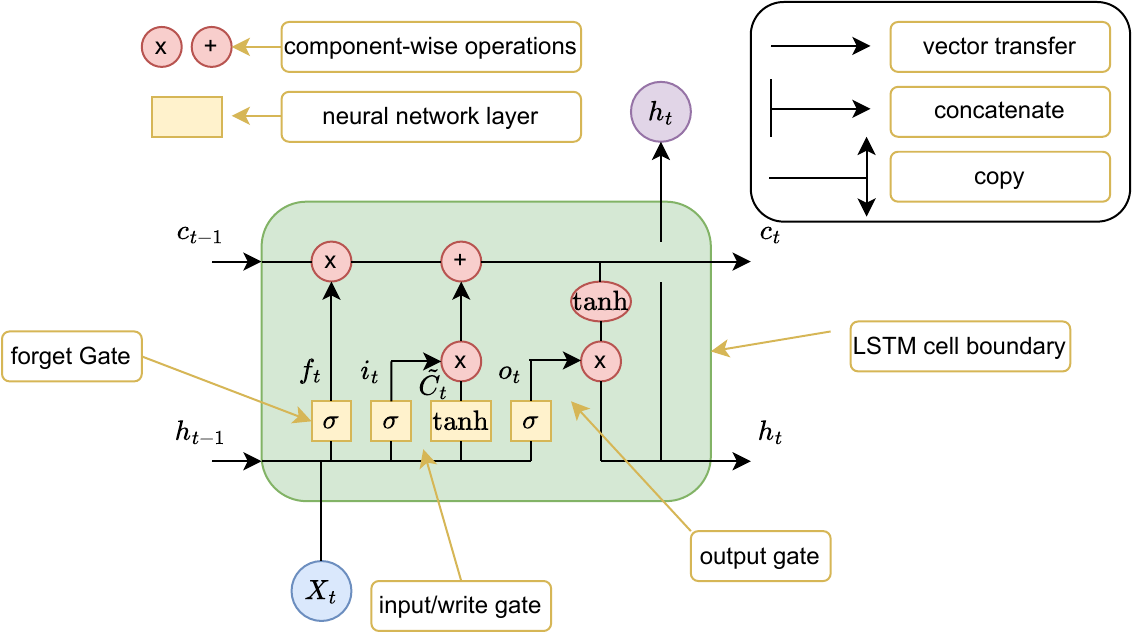

In [9]:
images = convert_from_path("/content/LSTMCell.pdf")
images[0]

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, mask):
        """
        Forwared pass of the model

        Args:
          x: Input tensor of shape (batch_size, seq_length, input_size)
          mask: Mask tensor of shape (batch_size, seq_length, input_size)

        Returns:
          out: The last timesteps hidden state
        """
        # Replace NaNs in the input with 0
        x = torch.nan_to_num(x, nan=0.0)
        # Apply the mask to ignore NaN features
        x = x * mask  # Element-wise multiplication

        # LSTM layer
        out, _ = self.lstm(x)  # Ignore the hidden and cell states
        # Fully connected layer (use only the last time-step's hidden state)
        out = self.fc(out[:, -1, :])

        return out

# Dataset

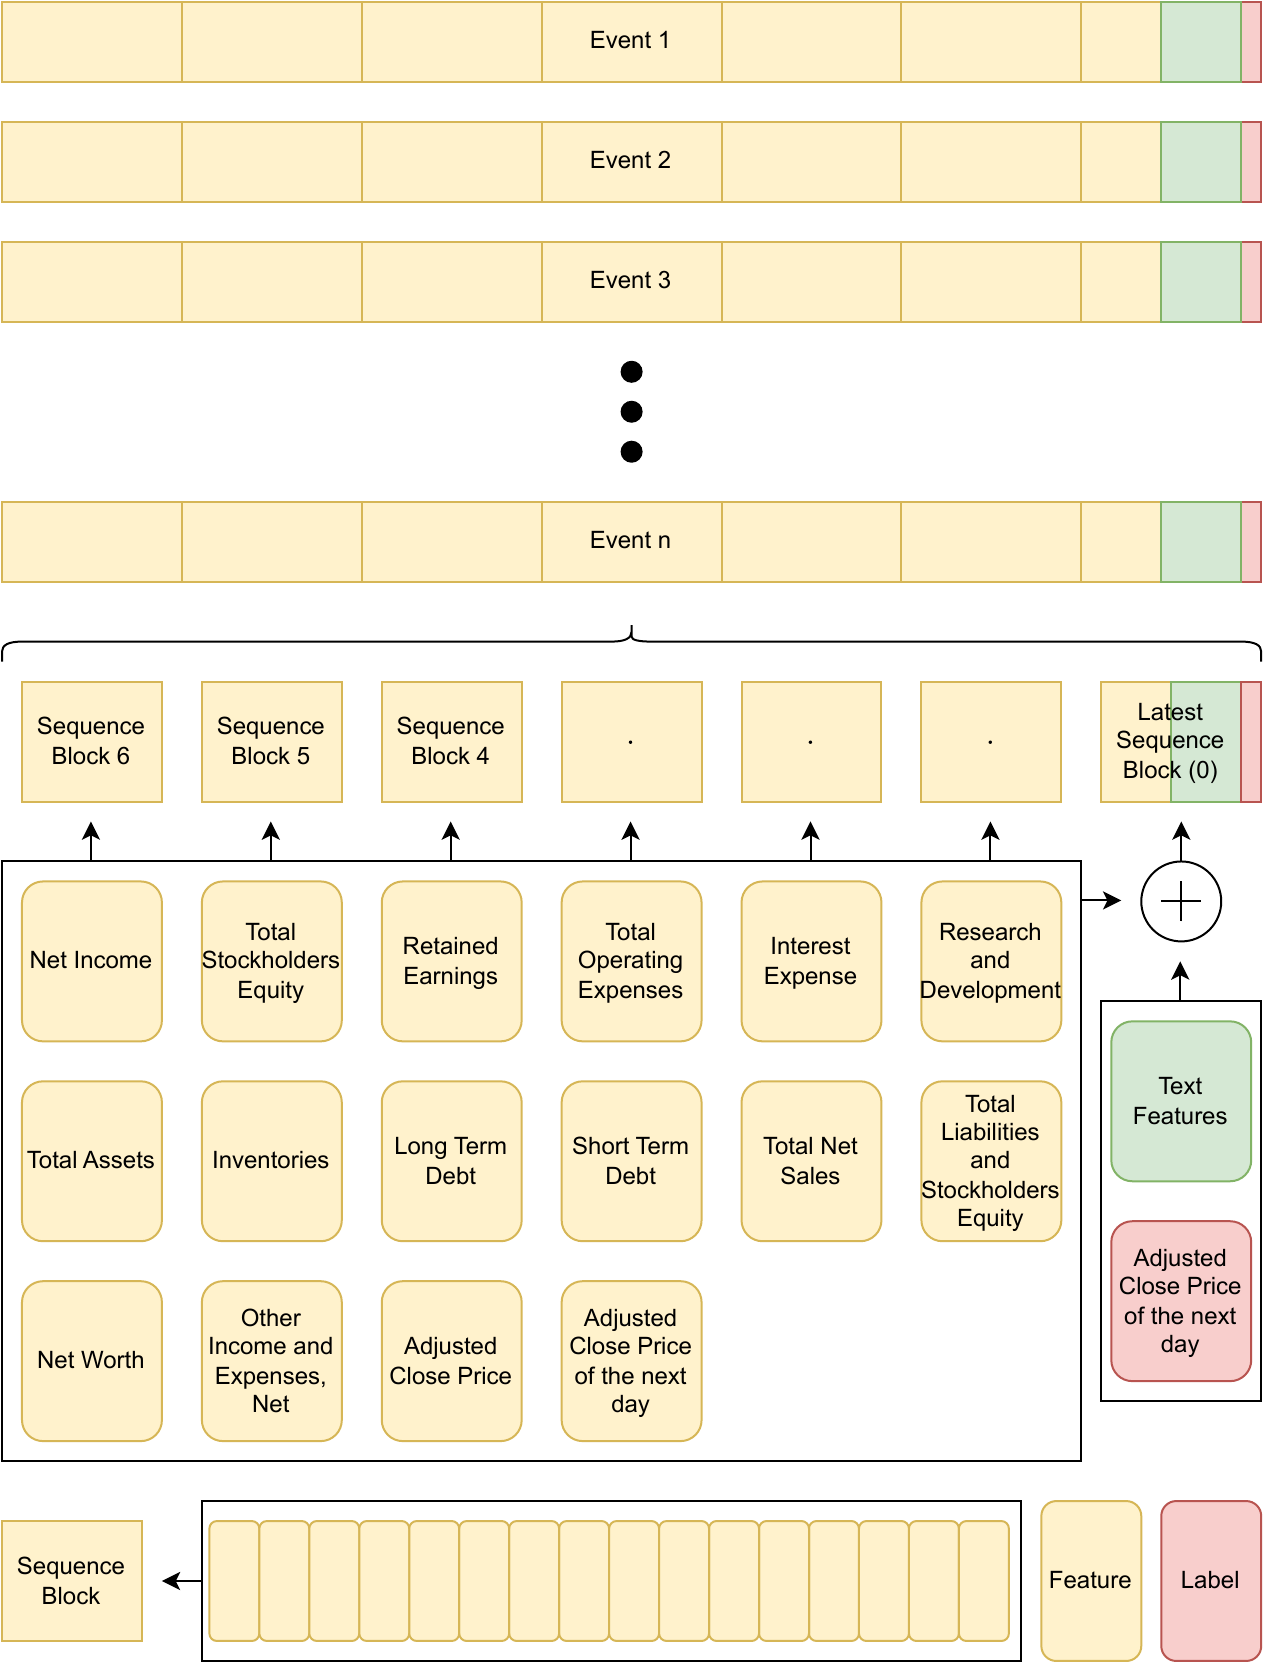

In [11]:
images = convert_from_path("/content/Dataset_structure.pdf")
images[0]

In [12]:
class LSTMDataset(Dataset):
    def __init__(self, numerical_rows, text_rows): #, nonsequence_data
        """
        Controlled environment for feeding models training samples

        Args:
            numerical_rows: numerical features
            text_rows: text features

        Returns: combined_sequences, mask, label: single training sample for the model
        """
        self.numerical_rows = numerical_rows
        self.text_rows = text_rows

    def __len__(self):
        return len(self.numerical_rows)

    def __getitem__(self, idx):

        #copy the rows to not manipulate the original ones
        row = self.numerical_rows[idx].copy()
        text_row = self.text_rows[idx].copy()

        #pad each sequence with len(text_dim) with nans
        shape_tensor = torch.tensor(row, dtype=torch.float32)

        #number Text features
        n = 16

        padded_sequences = torch.full((7, 16 + n), float('nan'))

        padded_sequences[:, :16] = shape_tensor

        padded_sequences[6, -n:] = torch.tensor(text_row[:n], dtype=torch.float32)

        row = padded_sequences.numpy()

        #add the text features only in the last sequence

        predicted = row[6, 0]  # Missing 0th feature of Sequence 7

        row[6, 0] = np.nan  # Simulate missing feature in the latest sequence

        combined_sequences = row[0:7, :]  # Sequences 0-6 go from furthest in the past to latest

        # Create a mask for valid features (1.0 for valid, 0.0 for NaN)
        mask = ~np.isnan(combined_sequences)  # Binary mask
        mask = torch.tensor(mask, dtype=torch.float32)

        # Replace NaNs in sequences with 0.0
        combined_sequences = torch.tensor(combined_sequences, dtype=torch.float32)
        combined_sequences = torch.nan_to_num(combined_sequences, nan=0.0)

        label = torch.tensor(predicted, dtype=torch.float32).unsqueeze(0)

        return combined_sequences, mask, label

# Train Validation Test Split

In [13]:
def train_val_test_split_dataset(dataset, train_ratio=0.8): # need val as well
    """
    Splits a dataset into train, validation and test sets.

    Args:
        dataset (Dataset): The dataset to split.
        train_ratio (float): Ratio of training data (default=0.8).

    Returns:
        train_dataset, val_dataset, test_dataset (Dataset, Dataset, Dataset): The train, validation and test datasets.
    """

    train_size = int(train_ratio * len(dataset))
    remainder = len(dataset) - train_size
    val_size = int(remainder//2) # because of floor division, might be one less than testset
    test_size = len(dataset) - train_size - val_size

    train_set = Subset(dataset, range(0, train_size))
    val_set = Subset(dataset, range(train_size, train_size + val_size))
    test_set = Subset(dataset, range(train_size + val_size, len(dataset)))
    return train_set, val_set, test_set

# Dataset creation

- keep the following columns for training the model

In [14]:
adj_close = ['Adj Close', '1 prior Adj Close', '2 prior Adj Close', '3 prior Adj Close', '4 prior Adj Close', '5 prior Adj Close', '6 prior Adj Close']
stock_movement_1 = ['Stock movement 1', '1 prior Stock movement 1', '2 prior Stock movement 1', '3 prior Stock movement 1', '4 prior Stock movement 1', '5 prior Stock movement 1', '6 prior Stock movement 1']

net_income = ['net income', '1 prior net income', '2 prior net income', '3 prior net income', '4 prior net income', '5 prior net income', '6 prior net income']
total_stockholders_equity = ['total stockholders’ equity', '1 prior total stockholders’ equity', '2 prior total stockholders’ equity', '3 prior total stockholders’ equity', '4 prior total stockholders’ equity', '5 prior total stockholders’ equity', '6 prior total stockholders’ equity']
retained_earnings = ['retained earnings', '1 prior retained earnings', '2 prior retained earnings', '3 prior retained earnings', '4 prior retained earnings', '5 prior retained earnings', '6 prior retained earnings']
total_operating_expenses = ['total operating expenses', '1 prior total operating expenses', '2 prior total operating expenses', '3 prior total operating expenses', '4 prior total operating expenses', '5 prior total operating expenses', '6 prior total operating expenses']
interest_expense = ['interest expense', '1 prior interest expense', '2 prior interest expense', '3 prior interest expense', '4 prior interest expense', '5 prior interest expense', '6 prior interest expense']
research_and_development = ['research and development', '1 prior research and development', '2 prior research and development', '3 prior research and development', '4 prior research and development', '5 prior research and development', '6 prior research and development']
net_worth = ['net worth', '1 prior net worth', '2 prior net worth', '3 prior net worth', '4 prior net worth', '5 prior net worth', '6 prior net worth']
total_assets = ['total assets', '1 prior total assets', '2 prior total assets', '3 prior total assets', '4 prior total assets', '5 prior total assets', '6 prior total assets']
inventories = ['inventories', '1 prior inventories', '2 prior inventories', '3 prior inventories', '4 prior inventories', '5 prior inventories', '6 prior inventories']
long_term_debt = ['long-term debt', '1 prior long-term debt', '2 prior long-term debt', '3 prior long-term debt', '4 prior long-term debt', '5 prior long-term debt', '6 prior long-term debt']
short_term_debt = ['short-term debt', '1 prior short-term debt', '2 prior short-term debt', '3 prior short-term debt', '4 prior short-term debt', '5 prior short-term debt', '6 prior short-term debt']
total_net_sales = ['total net sales', '1 prior total net sales', '2 prior total net sales', '3 prior total net sales', '4 prior total net sales', '5 prior total net sales', '6 prior total net sales']
total_liabilities_and_stockholders_equity = ['total liabilities and stockholders’ equity', '1 prior total liabilities and stockholders’ equity', '2 prior total liabilities and stockholders’ equity', '3 prior total liabilities and stockholders’ equity', '4 prior total liabilities and stockholders’ equity', '5 prior total liabilities and stockholders’ equity', '6 prior total liabilities and stockholders’ equity']
other_income_expense_net = ['other income (expense), net', '1 prior other income (expense), net', '2 prior other income (expense), net', '3 prior other income (expense), net', '4 prior other income (expense), net', '5 prior other income (expense), net', '6 prior other income (expense), net']

past_cols = [f'past {i}' for i in range(51)]
future_cols = [f'future {i}' for i in range(51)]
present_col = ["Present"]

In [15]:
path = "/content/ML-Pipeline/prediction_dataset.csv"
final_df = pd.read_csv(path, index_col=0)

In [16]:
final_df.tail(1)

,datetime,6 prior Stock movement 1,6 prior Adj Close,6 prior net income,6 prior total stockholders’ equity,6 prior retained earnings,6 prior total operating expenses,6 prior interest expense,6 prior research and development,6 prior net worth,...,future 41,future 42,future 43,future 44,future 45,future 46,future 47,future 48,future 49,future 50
35989,2024-10-07 16:57:32,189.177811,212.301285,1770772.0,6038312.0,NaN,330694.0,28559.0,25514.0,NaN,...,217.429993,215.889999,215.630005,214.220001,209.619995,216.410004,214.220001,211.029999,209.509995,207.009995


## Filtering the dataframe

- remove corrupt entries
- keeping only a certain daterange due to the way the dataset was created
- separate the text and the numerical features

In [17]:
# Test input vectors:
# remove where adj_close and or stock movement 1 are nan
# ticker mismatch with yfinance
final_df_no_nan = final_df[(final_df["Ticker"] != "HCIIP") & (final_df["Ticker"] != "O-P")]

# Start 7 Quarters after the start of Crawling
filtered_df = final_df_no_nan[final_df_no_nan['datetime'] > '2021-09-01']

Uncomment to test on 8Ks or 10K/10Qs:

In [18]:
# Uncomment to test on only 8K / 10Ks 10Qs
# filtered_df = filtered_df[filtered_df["10"].notna()] #10Ks 10Qs
# filtered_df = filtered_df[filtered_df["10"].isna()] # 8Ks

In [19]:
# Get the text vector separately
filtered_df_text = filtered_df.iloc[:, 113]

# Ticker list
ticker_list = final_df['Ticker'].unique().tolist()

Example:

In [20]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

filtered_df[filtered_df['Ticker'] == "GE"].head(1)

,datetime,6 prior Stock movement 1,6 prior Adj Close,6 prior net income,6 prior total stockholders’ equity,6 prior retained earnings,6 prior total operating expenses,6 prior interest expense,6 prior research and development,6 prior net worth,6 prior total assets,6 prior inventories,6 prior long-term debt,6 prior short-term debt,6 prior total net sales,6 prior total liabilities and stockholders’ equity,"6 prior other income (expense), net",5 prior Stock movement 1,5 prior Adj Close,5 prior net income,5 prior total stockholders’ equity,5 prior retained earnings,5 prior total operating expenses,5 prior interest expense,5 prior research and development,5 prior net worth,5 prior total assets,5 prior inventories,5 prior long-term debt,5 prior short-term debt,5 prior total net sales,5 prior total liabilities and stockholders’ equity,"5 prior other income (expense), net",4 prior Stock movement 1,4 prior Adj Close,4 prior net income,4 prior total stockholders’ equity,4 prior retained earnings,4 prior total operating expenses,4 prior interest expense,4 prior research and development,4 prior net worth,4 prior total assets,4 prior inventories,4 prior long-term debt,4 prior short-term debt,4 prior total net sales,4 prior total liabilities and stockholders’ equity,"4 prior other income (expense), net",3 prior Stock movement 1,3 prior Adj Close,3 prior net income,3 prior total stockholders’ equity,3 prior retained earnings,3 prior total operating expenses,3 prior interest expense,3 prior research and development,3 prior net worth,3 prior total assets,3 prior inventories,3 prior long-term debt,3 prior short-term debt,3 prior total net sales,3 prior total liabilities and stockholders’ equity,"3 prior other income (expense), net",2 prior Stock movement 1,2 prior Adj Close,2 prior net income,2 prior total stockholders’ equity,2 prior retained earnings,2 prior total operating expenses,2 prior interest expense,2 prior research and development,2 prior net worth,2 prior total assets,2 prior inventories,2 prior long-term debt,2 prior short-term debt,2 prior total net sales,2 prior total liabilities and stockholders’ equity,"2 prior other income (expense), net",1 prior Stock movement 1,1 prior Adj Close,1 prior net income,1 prior total stockholders’ equity,1 prior retained earnings,1 prior total operating expenses,1 prior interest expense,1 prior research and development,1 prior net worth,1 prior total assets,1 prior inventories,1 prior long-term debt,1 prior short-term debt,1 prior total net sales,1 prior total liabilities and stockholders’ equity,"1 prior other income (expense), net",Stock movement 1,Adj Close,net income,total stockholders’ equity,retained earnings,total operating expenses,interest expense,research and development,net worth,total assets,inventories,long-term debt,short-term debt,total net sales,total liabilities and stockholders’ equity,"other income (expense), net",summarized_doc_vector,Date,Time,Ticker,10,past 50,past 49,past 48,past 47,past 46,past 45,past 44,past 43,past 42,past 41,past 40,past 39,past 38,past 37,past 36,past 35,past 34,past 33,past 32,past 31,past 30,past 29,past 28,past 27,past 26,past 25,past 24,past 23,past 22,past 21,past 20,past 19,past 18,past 17,past 16,past 15,past 14,past 13,past 12,past 11,past 10,past 9,past 8,past 7,past 6,past 5,past 4,past 3,past 2,past 1,past 0,Present,future 0,future 1,future 2,future 3,future 4,future 5,future 6,future 7,future 8,future 9,future 10,future 11,future 12,future 13,future 14,future 15,future 16,future 17,future 18,future 19,future 20,future 21,future 22,future 23,future 24,future 25,future 26,future 27,future 28,future 29,future 30,future 31,future 32,future 33,future 34,future 35,future 36,future 37,future 38,future 39,future 40,future 41,future 42,future 43,future 44,future 45,future 46,future 47,future 48,future 49,future 50
17054,2021-09-23 08:17:12,48.689625,49.323868,-9383.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.238354,32.162991,6233.0,NaN,Na

# Normalization

##  Scale the word vectors to be in the range of [0,1]

In [21]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [22]:
print(filtered_df_text.head(2))

text_rows_df = filtered_df_text.values
text_rows = np.zeros((len(text_rows_df), 16)) #to 16 or 300
for i in range(len(text_rows_df)):
  text_rows[i] = np.fromstring(text_rows_df[i].strip("[]"), sep=' ')
  text_rows[i] = sigmoid(text_rows[i])

print(text_rows[1])

16798    [-0.38586894 -0.12805972  0.06614992  0.127316...
16799    [-0.4836791  -0.11781356  0.11570733  0.060129...
Name: summarized_doc_vector, dtype: object
[0.38138374 0.47058063 0.5288946  0.51502795 0.70758425 0.56683845
 0.54942071 0.45279007 0.40260779 0.35762245 0.61152061 0.37394153
 0.54910703 0.50172075 0.55768252 0.55324896]


## Scale the KPIs to be in the range of 0 and 1

Define the scaling range:

In [23]:
scaling_min, scaling_max = 0, 1

Normalize the following columns:

In [24]:
kpis_to_normalize = [net_income, total_stockholders_equity, retained_earnings, total_operating_expenses, interest_expense, research_and_development, net_worth, total_assets, inventories, long_term_debt, short_term_debt, total_net_sales, total_liabilities_and_stockholders_equity, other_income_expense_net]

In [25]:
# Normalize the numerical rows

for ticker in ticker_list:
  for column in kpis_to_normalize:
    subset = filtered_df.loc[filtered_df['Ticker'] == ticker, column]

    # Calculate global min and max for this ticker
    global_min = subset.min()
    global_max = subset.max()

    # Apply the custom normalization formula
    X_std = (subset - global_min) / (global_max - global_min)
    normalized_values = X_std * (scaling_max - scaling_min) + scaling_min

    # Step 3: Assign the normalized subset back to the selected rows in the original DataFrame
    filtered_df.loc[filtered_df['Ticker'] == ticker, column] = normalized_values

## Normalize Stock prices

In [26]:
stock_prices_to_normalize = [adj_close, stock_movement_1, past_cols, future_cols, present_col]

In [27]:
# Flatten the list of lists into a single list
flat_stock_prices_to_normalize = [col for sublist in stock_prices_to_normalize for col in sublist]

min_values = {}
scale_values = {}

In [28]:
# Step 2: Normalize the selected subset
for ticker in ticker_list:
    # Select the subset of columns for the current ticker
    subset = filtered_df.loc[filtered_df['Ticker'] == ticker, flat_stock_prices_to_normalize]

    # Calculate global min and max across all columns for this ticker
    global_min = subset.min().min()
    global_max = subset.max().max()

    # Apply the custom normalization formula
    X_std = (subset - global_min) / (global_max - global_min)
    normalized_values = X_std * (scaling_max - scaling_min) + scaling_min

    # Replace the values back into the DataFrame
    filtered_df.loc[filtered_df['Ticker'] == ticker, flat_stock_prices_to_normalize] = normalized_values

    # Store global min and max for future denormalization
    min_values[ticker] = global_min
    scale_values[ticker] = global_max - global_min

Store the numerical data

In [29]:
filtered_df_numerical = filtered_df.iloc[:, 1:113] # ONLY numerical, first one is datetime

filtered_df_numerical.head(1)

,6 prior Stock movement 1,6 prior Adj Close,6 prior net income,6 prior total stockholders’ equity,6 prior retained earnings,6 prior total operating expenses,6 prior interest expense,6 prior research and development,6 prior net worth,6 prior total assets,6 prior inventories,6 prior long-term debt,6 prior short-term debt,6 prior total net sales,6 prior total liabilities and stockholders’ equity,"6 prior other income (expense), net",5 prior Stock movement 1,5 prior Adj Close,5 prior net income,5 prior total stockholders’ equity,5 prior retained earnings,5 prior total operating expenses,5 prior interest expense,5 prior research and development,5 prior net worth,5 prior total assets,5 prior inventories,5 prior long-term debt,5 prior short-term debt,5 prior total net sales,5 prior total liabilities and stockholders’ equity,"5 prior other income (expense), net",4 prior Stock movement 1,4 prior Adj Close,4 prior net income,4 prior total stockholders’ equity,4 prior retained earnings,4 prior total operating expenses,4 prior interest expense,4 prior research and development,4 prior net worth,4 prior total assets,4 prior inventories,4 prior long-term debt,4 prior short-term debt,4 prior total net sales,4 prior total liabilities and stockholders’ equity,"4 prior other income (expense), net",3 prior Stock movement 1,3 prior Adj Close,3 prior net income,3 prior total stockholders’ equity,3 prior retained earnings,3 prior total operating expenses,3 prior interest expense,3 prior research and development,3 prior net worth,3 prior total assets,3 prior inventories,3 prior long-term debt,3 prior short-term debt,3 prior total net sales,3 prior total liabilities and stockholders’ equity,"3 prior other income (expense), net",2 prior Stock movement 1,2 prior Adj Close,2 prior net income,2 prior total stockholders’ equity,2 prior retained earnings,2 prior total operating expenses,2 prior interest expense,2 prior research and development,2 prior net worth,2 prior total assets,2 prior inventories,2 prior long-term debt,2 prior short-term debt,2 prior total net sales,2 prior total liabilities and stockholders’ equity,"2 prior other income (expense), net",1 prior Stock movement 1,1 prior Adj Close,1 prior net income,1 prior total stockholders’ equity,1 prior retained earnings,1 prior total operating expenses,1 prior interest expense,1 prior research and development,1 prior net worth,1 prior total assets,1 prior inventories,1 prior long-term debt,1 prior short-term debt,1 prior total net sales,1 prior total liabilities and stockholders’ equity,"1 prior other income (expense), net",Stock movement 1,Adj Close,net income,total stockholders’ equity,retained earnings,total operating expenses,interest expense,research and development,net worth,total assets,inventories,long-term debt,short-term debt,total net sales,total liabilities and stockholders’ equity,"other income (expense), net"
16798,0.0,0.046485,0.018565,NaN,NaN,NaN,NaN,NaN,NaN,0.131845,0.0,0.969163,0.115826,NaN,NaN,NaN,0.129365,0.13251,0.011472,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.779811,0.105313,NaN,NaN,NaN,0.292156,0.308608,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.102205,0.86686,0.134174,NaN,NaN,NaN,0.497858,0.464512,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.075309,0.879588,0.0,NaN,NaN,NaN,0.656483,0.664686,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.147457,0.0,1.0,0.0,NaN,NaN,NaN,0.600841,0.596136,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.22376,0.134189,0.985346,0.022603,NaN,NaN,NaN,0.772038,0.753654,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.379588,0.164527,1.0,0.071682,NaN,NaN,NaN


Store the Labels

In [30]:
label_rows = filtered_df.iloc[:, 170:] # ONLY numerical

label_rows.head(1)

,future 0,future 1,future 2,future 3,future 4,future 5,future 6,future 7,future 8,future 9,future 10,future 11,future 12,future 13,future 14,future 15,future 16,future 17,future 18,future 19,future 20,future 21,future 22,future 23,future 24,future 25,future 26,future 27,future 28,future 29,future 30,future 31,future 32,future 33,future 34,future 35,future 36,future 37,future 38,future 39,future 40,future 41,future 42,future 43,future 44,future 45,future 46,future 47,future 48,future 49,future 50
16798,0.772038,0.779628,0.770351,0.781652,0.763436,0.777267,0.740499,0.747751,0.755172,0.754329,0.743366,0.710984,0.715369,0.707273,0.718236,0.70255,0.638629,0.607596,0.619739,0.597308,0.581791,0.553456,0.55936,0.569647,0.593597,0.601693,0.576225,0.583646,0.578249,0.595519,0.594164,0.582821,0.625487,0.692703,0.722163,0.750437,0.748067,0.77431,0.767199,0.767199,0.787178,0.788024,0.767199,0.783961,0.790564,0.71065,0.751792,0.745527,0.769061,0.759411,0.779728


In [31]:
# Additional prediction rows up to and including Present
timeseries_rows = filtered_df.iloc[:, 118:170]

timeseries_rows.head(1)

,past 50,past 49,past 48,past 47,past 46,past 45,past 44,past 43,past 42,past 41,past 40,past 39,past 38,past 37,past 36,past 35,past 34,past 33,past 32,past 31,past 30,past 29,past 28,past 27,past 26,past 25,past 24,past 23,past 22,past 21,past 20,past 19,past 18,past 17,past 16,past 15,past 14,past 13,past 12,past 11,past 10,past 9,past 8,past 7,past 6,past 5,past 4,past 3,past 2,past 1,past 0,Present
16798,0.43971,0.441222,0.453151,0.417868,0.43719,0.455672,0.45164,0.461217,0.460041,0.45416,0.480539,0.458697,0.477347,0.469282,0.467265,0.481715,0.498853,0.548923,0.574293,0.552787,0.573454,0.588239,0.601344,0.618987,0.608738,0.616802,0.601176,0.598488,0.581116,0.572515,0.586851,0.608439,0.607427,0.611644,0.599331,0.642339,0.620751,0.625642,0.637617,0.64723,0.645376,0.644364,0.664602,0.655326,0.66612,0.665446,0.682143,0.674384,0.653471,0.67624,0.680456,0.753654


Adjust the shape of the numerical rows to fit the thought of Model/Dataset architecture

In [32]:
numerical_rows = np.array(filtered_df_numerical.values)

numerical_rows = numerical_rows.reshape(len(numerical_rows),7, 16)

print(numerical_rows[0])

[[0.         0.04648538 0.01856487        nan        nan        nan
         nan        nan        nan 0.13184464 0.         0.969163
  0.11582569        nan        nan        nan]
 [0.12936473 0.13250968 0.01147171        nan        nan        nan
         nan        nan        nan 0.         0.         0.7798111
  0.10531346        nan        nan        nan]
 [0.29215571 0.30860751 0.                nan        nan        nan
         nan        nan        nan 0.         0.10220549 0.86685962
  0.13417431        nan        nan        nan]
 [0.49785821 0.46451162 0.                nan        nan        nan
         nan        nan        nan 0.         0.07530931 0.87958818
  0.                nan        nan        nan]
 [0.65648285 0.66468614 0.                nan        nan        nan
         nan        nan        nan 0.14745654 0.         1.
  0.                nan        nan        nan]
 [0.6008407  0.59613585 0.                nan        nan        nan
         nan        nan     

# Input into Dataset

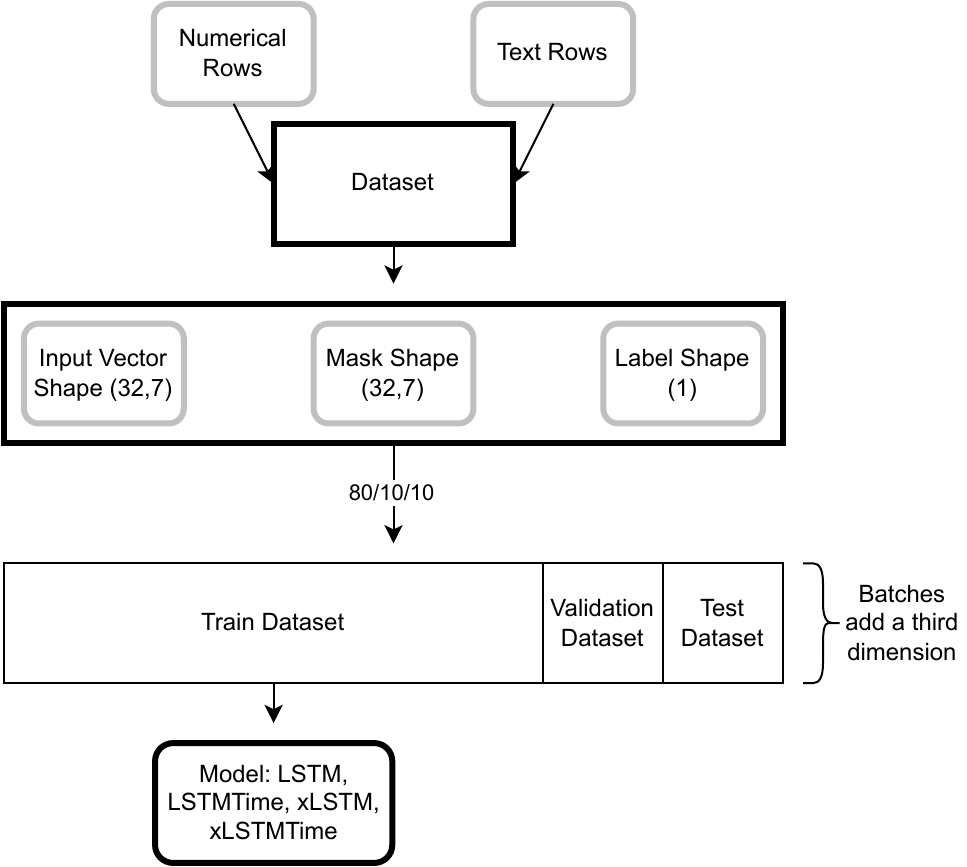

In [33]:
images = convert_from_path("/content/model_pipeline.pdf")
images[0]

In [34]:
dataset = LSTMDataset(numerical_rows=numerical_rows, text_rows=text_rows)

# Split the Dataset

In [35]:
train_dataset, val_dataset, test_dataset = train_val_test_split_dataset(dataset, train_ratio=0.8) #80/10/10 can change, val and test always have the same length

# Fetch an example
sequences, mask, label = train_dataset[0]
print("Sequences:\n", sequences)
print("Mask:\n", mask)
print("Label:\n", label)

Sequences:
 tensor([[0.0000, 0.0465, 0.0186, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.1318, 0.0000, 0.9692, 0.1158, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1294, 0.1325, 0.0115, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.7798, 0.1053, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2922, 0.3086, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.1022, 0.8669, 0.1342, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4979, 0.4645, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0753, 0.8

# Dataloader

In [36]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Checking for nan labels in the Dataset:

In [37]:
dataloader_monitor = DataLoader(dataset, batch_size=1,shuffle=False)

nan_label_rows = []
label_tensors = []

for batch_indices in dataloader_monitor.batch_sampler:
    for idx in batch_indices:
      _, _, label = dataset[idx]
      label_tensors.append(label)
      if torch.isnan(label) or torch.isinf(label).any():
        print(f"Batch indices: {batch_indices}")
        nan_label_rows.append(batch_indices)

print(len(nan_label_rows))

print("Max target value:", max(label_tensors))
print("Min target value:", min(label_tensors))

0
Max target value: tensor([1.])
Min target value: tensor([0.])


# Training Loop

## Model Parameters

The **learning rate** determines how much the weights of the model are adjusted during
each step of training. We changed it in steps of 10 to find a good spot to:

1. not overshoot the optimal solution and introduce instability in the training
2. and to not make the training too slow and/or get stuck in local minima

The **batch size** is the number of training examples the model processes before updating its
parameters. We increased the batch size at powers of two until we found a good working
solution. In keeping the batch size mostly smaller the updates are more stochastic and help
escaping local minima, which was a problem when the batch size was too large. Each epoch
indicates a complete pass through the entire training dataset, we adjusted this accordingly
to not over- or under-fit the model. To see if the model was overfitting we used a validation
set.

The **sequence length** determines how many consecutive elements are processed at once. In
our case it is 7 with an **input size** of 32 and an **output size** of 1. The input size or embedding
size is the number of features that are fed to the model at the same time and the output
size is the number of model outputs.

To penalize peaky weights, a **weight decay** can be used, with its regularization strength depicted as lambda. Depending on the regularization it does or does not affect the previous gradient.

In [38]:
import time

In [39]:
nr_text_features = 16
input_size = 16 + nr_text_features
seq_length = 7
hidden_size = 32
output_size = 1
num_epochs = 25
learning_rate = 0.0001

lamb = 0.0 # Lambda

# Initialize model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lamb) # weight decay - does not affect the previous gradient

#L2 regularization - affects the previous gradient
# for param in model.parameters():
#   loss += 0.5 * lamb * torch.sum(param**2)

# Record the start time of the training
total_start_time = time.time()

train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    train_loss = 0
    for batch_X, mask, batch_y in train_loader:
        outputs = model(batch_X.to(device), mask.to(device))
        loss = criterion(outputs, batch_y.to(device))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader)) # Average train loss

    model.eval()
    val_loss = 0
    with torch.no_grad():
      for batch_X, mask, batch_y in validation_loader:
        outputs = model(batch_X.to(device), mask.to(device))

        loss = criterion(outputs, batch_y.to(device))
        val_loss += loss.item()

    val_losses.append(val_loss / len(validation_loader))  # Average validation loss

    # Calculate the time taken for the epoch
    epoch_time = time.time() - start_time

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss (MSE): {train_loss/len(train_loader):.4f}, "
          f"Val Loss (MSE): {val_loss/len(validation_loader):.4f}, "
          f"Time: {epoch_time:.2f} seconds")

# Record the end time of the training
total_end_time = time.time()
total_training_time = total_end_time - total_start_time

print(f"Total training time: {total_training_time:.2f} seconds")

Epoch [1/25], Train Loss (MSE): 0.0662, Val Loss (MSE): 0.0579, Time: 4.06 seconds
Epoch [2/25], Train Loss (MSE): 0.0371, Val Loss (MSE): 0.0426, Time: 7.37 seconds
Epoch [3/25], Train Loss (MSE): 0.0294, Val Loss (MSE): 0.0321, Time: 3.87 seconds
Epoch [4/25], Train Loss (MSE): 0.0239, Val Loss (MSE): 0.0250, Time: 3.88 seconds
Epoch [5/25], Train Loss (MSE): 0.0189, Val Loss (MSE): 0.0187, Time: 4.68 seconds
Epoch [6/25], Train Loss (MSE): 0.0141, Val Loss (MSE): 0.0131, Time: 3.88 seconds
Epoch [7/25], Train Loss (MSE): 0.0100, Val Loss (MSE): 0.0089, Time: 3.99 seconds
Epoch [8/25], Train Loss (MSE): 0.0070, Val Loss (MSE): 0.0061, Time: 4.74 seconds
Epoch [9/25], Train Loss (MSE): 0.0048, Val Loss (MSE): 0.0041, Time: 3.88 seconds
Epoch [10/25], Train Loss (MSE): 0.0032, Val Loss (MSE): 0.0027, Time: 3.90 seconds
Epoch [11/25], Train Loss (MSE): 0.0022, Val Loss (MSE): 0.0019, Time: 4.80 seconds
Epoch [12/25], Train Loss (MSE): 0.0017, Val Loss (MSE): 0.0015, Time: 3.85 seconds
E

## Learning Curve

In [40]:
import matplotlib.pyplot as plt

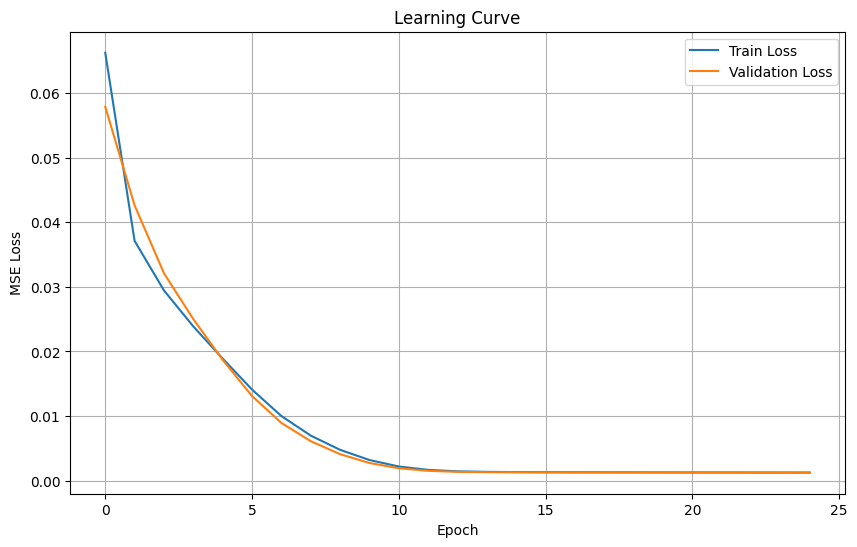

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)

plt.savefig('learning_curveLSTM.pdf', format='pdf', bbox_inches='tight') # adjust dpi=300 for higher resolution

plt.show()

## Shapely Analysis

In [42]:
import shap

# Ensure SHAP JS visualizations are enabled
shap.initjs()

In [43]:
# get the column names
numerical_columns = filtered_df_numerical.columns
numerical_text_columns = []

sequence_counter = 6
for i in range(len(numerical_columns)):
  numerical_text_columns.append(numerical_columns[i])
  if (i > 14) and (i % 16 == 15):
    for idx in range(16):
      numerical_text_columns.append(str(sequence_counter) + "text feature" + str(idx))
    sequence_counter = sequence_counter -1

In [44]:
%%script echo skipping
for name, param in model.named_parameters():
    print(f"{name} is on {param.device}")

skipping


/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f"unrecognized nn.Module: {module_type}")


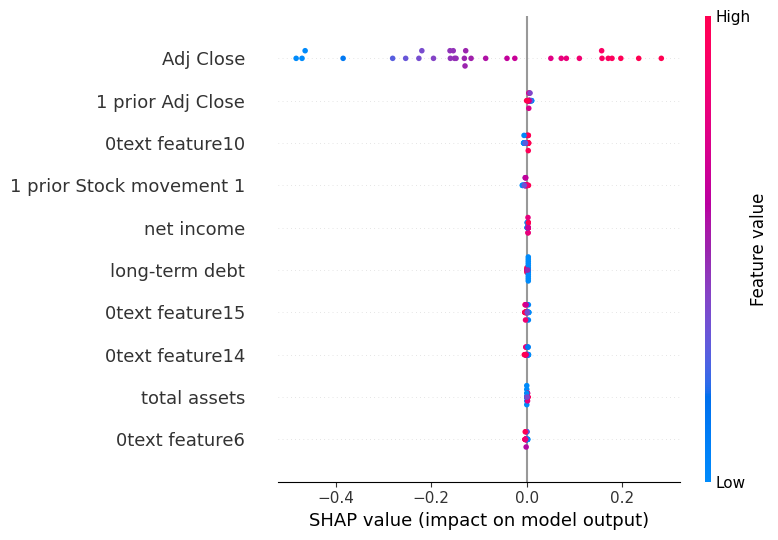

In [45]:
# Get a representative batch for the background data
background_batch = next(iter(train_loader))
background_data = background_batch[0].cpu()  # Shape: (batch_size, seq_length, input_size)
background_mask = background_batch[1].cpu()

# Prepare background data as a list of inputs for the model
cpu_background_data = [background_data, background_mask]

# Get a batch of data to explain
explain_batch = next(iter(validation_loader))
input_data_to_explain = explain_batch[0].cpu()  # Shape: (batch_size, seq_length, input_size)
input_mask_to_explain = explain_batch[1].cpu()

# Prepare the data to be explained in the same format as the model expects
cpu_input_data_to_explain = [input_data_to_explain, input_mask_to_explain]

# Define the SHAP explainer using DeepExplainer
explainer = shap.DeepExplainer(model.cpu(), cpu_background_data)

# Compute SHAP values for the data to explain
shap_values = explainer.shap_values(cpu_input_data_to_explain, check_additivity=False)

# Convert SHAP values to numpy array and extract the input feature explanations
shap_values_np = np.array(shap_values[0])  # Select only input feature SHAP values

# Remove the singleton dimension
shap_values_np = np.squeeze(shap_values_np, axis=-1)  # Shape: (32, 7, 32)

# Convert input data to numpy array
input_data_np = input_data_to_explain.numpy()  # Shape: (32, 7, 32)

# Ensure shapes match
assert shap_values_np.shape == input_data_np.shape, \
    f"SHAP values shape {shap_values_np.shape} does not match input data shape {input_data_np.shape}"

# Flatten sequence length and features for visualization
shap_values_flat = shap_values_np.reshape(shap_values_np.shape[0], -1)  # Shape: (32, 224)
input_data_flat = input_data_np.reshape(input_data_np.shape[0], -1)     # Shape: (32, 224)

# Ensure feature names match the flattened data
assert len(numerical_text_columns) == input_data_flat.shape[1], \
    f"Feature names length {len(numerical_text_columns)} does not match input data columns {input_data_flat.shape[1]}"

# Convert input data to DataFrame for better compatibility with SHAP
input_data_df = pd.DataFrame(input_data_flat, columns=numerical_text_columns)

# Generate the summary plot (use simplified input types to avoid serialization issues)
# max_display=10 shows the 10 most impactful features
shap.summary_plot(shap_values_flat, input_data_flat, feature_names=numerical_text_columns, max_display=10, show=False)

# Save the figure
plt.savefig('summaryplotLSTM.pdf', format='pdf', bbox_inches='tight')  # adjust dpi=300 for higher resolution if needed
plt.show()  # Close the plot to free up memory when running multiple plots

In [46]:
# Select a single instance to visualize
sample_index = 0  # Index of the sample to explain

output_index = 0

# Convert SHAP values and input features to lists
shap_values_sample = shap_values_flat[sample_index]  # Single sample SHAP values
input_data_sample = input_data_flat[sample_index]   # Single sample input features

# Flatten SHAP values and input features
shap_values_flattened = shap_values_sample.flatten()  # Shape: (224,)
input_data_flattened = input_data_sample.flatten()    # Shape: (224,)

# Create an Explanation object for the single instance
explanation = shap.Explanation(
    values=shap_values_sample,
    base_values=explainer.expected_value, # Base value (mean prediction for background data)
    data=input_data_sample,
    feature_names=numerical_text_columns
)

# Generate the force plot
force_plot_html = shap.force_plot(
    explanation.base_values,  # Single base value
    explanation.values,       # SHAP values for the instance
    explanation.data,         # Input data for the instance
    feature_names=numerical_text_columns
)

# Save HTML to file
with open("force_plot.html", "w") as f:
    f.write(force_plot_html.html())

# Test Loop

In [47]:
%%script echo skipping
for name, param in model.named_parameters():
    print(f"{name} is on {param.device}")

skipping


In [48]:
model = model.to(device)

In [49]:
%%script echo skipping
for name, param in model.named_parameters():
    print(f"{name} is on {param.device}")

skipping


In [50]:
# Switch to evaluation mode
model.eval()

all_predictions = []
all_actuals = []

# Predict for all inputs
with torch.no_grad():
    for X_batch, mask, y_batch in test_loader:

        X_batch = X_batch.to(device)
        mask = mask.to(device)
        y_batch = y_batch.to(device)

        # Forward pass through the LSTM
        output = model(X_batch, mask)

        all_predictions.append(output.cpu())
        all_actuals.append(y_batch.cpu())

# Concatenate all predictions and actual values
all_predictions = torch.cat(all_predictions)
all_actuals = torch.cat(all_actuals)

print("Predictions:", all_predictions[:5])
print("Actuals:", all_actuals[:5])

Predictions: tensor([[0.8114],
        [0.4775],
        [0.2580],
        [0.7772],
        [0.5898]])
Actuals: tensor([[0.8085],
        [0.4954],
        [0.2741],
        [0.7556],
        [0.6055]])


# Evaluation

In [51]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from collections import Counter

Mean Absolute Error (MAE): 0.026
Mean Squared Error (MSE): 0.002
Root Mean Squared Error (RMSE): 0.042
R-squared (R2): 0.971


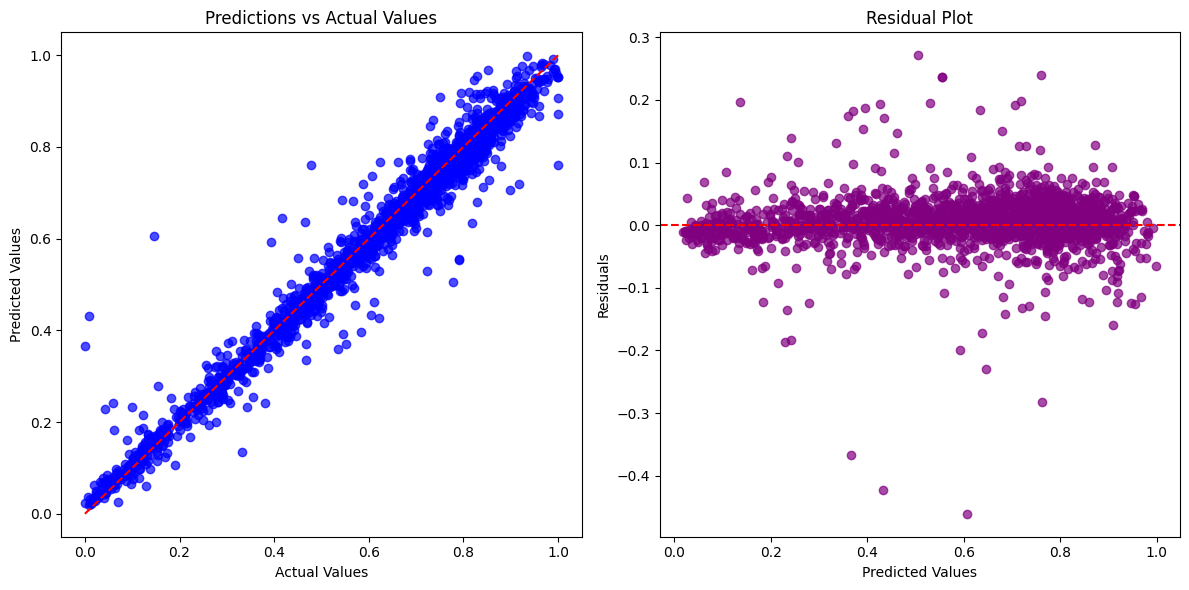

In [52]:
mae = mean_absolute_error(all_actuals, all_predictions)
mse = mean_squared_error(all_actuals, all_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(all_actuals.numpy(), all_predictions.numpy())

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R-squared (R2): {r2:.3f}")

# Visualization
plt.figure(figsize=(12, 6))

# Scatter Plot: Predictions vs Actual Values
plt.subplot(1, 2, 1)
plt.scatter(all_actuals, all_predictions, color='blue', alpha=0.7)
plt.plot([min(all_actuals), max(all_actuals)],
         [min(all_actuals), max(all_actuals)],
         color='red', linestyle='--')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values')

# Residual Plot
residuals = all_actuals - all_predictions
plt.subplot(1, 2, 2)
plt.scatter(all_predictions, residuals, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.tight_layout()

plt.savefig('predictionsvsactualsLSTM.pdf', format='pdf', bbox_inches='tight') # adjust dpi=300 for higher resolution

plt.show()

# Visualisation

In [53]:
def compute_direction(values, reference, threshold):
    """
    Compute the movement direction from the current to the label value

    Args:
      values: predicted/actual future values
      reference: values on the day of prediction
      threshold: To make it a tertiary calssification introduce a threshold for a neutral class

    Returns:
      directions (List): movement directions
    """
    changes = values - reference
    directions = 0
    if(changes > threshold):
      directions = 1
    elif(changes < -threshold):
      directions = -1

    #directions = int(changes > 0.01)#.astype(int)  # 1 if up, 0 if down
    return directions

In [54]:
def compute_difference(values, reference):
  """
  Calculate the Difference of two values

  Args:
    values: predicted/actual future values
    reference: values on the day of prediction

  Returns:
    difference: Difference of two values
  """
  difference = values - reference

  return difference

## Dataset

Filter the DataFrame: filtered_df to only look at specific Companies

In [55]:
# filtered_df_company = filtered_df.loc[filtered_df['Ticker'] == 'LW']

In [56]:
# Number Rows
print("Number of Rows/ Events:", len(filtered_df))

# Distribution of Labels
# Categories Higher, Lower, Same
train_to_actual = []
test_to_actual = []
validation_to_actual = []

values_day_of_prediction = filtered_df["Adj Close"].values
train_values_day_of_prediction, val_values_day_of_prediction, test_values_day_of_prediction = train_val_test_split_dataset(values_day_of_prediction)

true_values = filtered_df["Stock movement 1"].values
train_values_true, val_values_true, test_values_true = train_val_test_split_dataset(true_values)

for i in range(len(train_values_day_of_prediction)):
  # Train
  train_to_actual.append(compute_direction(train_values_day_of_prediction[i], train_values_true[i], 0.0))

print("Labels in the Training set:", Counter(train_to_actual))

for i in range(len(test_values_day_of_prediction)):
  # Validation
  test_to_actual.append(compute_direction(test_values_day_of_prediction[i], test_values_true[i], 0.0))

print("Labels in the Test set:", Counter(test_to_actual))

for i in range(len(val_values_day_of_prediction)):
  # Test
  validation_to_actual.append(compute_direction(val_values_day_of_prediction[i], val_values_true[i], 0.0))

print("Labels in the Validation set:", Counter(validation_to_actual))

# Number 8Ks
print("Number 8Ks:", len(filtered_df[filtered_df['10'].isna()]))
# Number 10Ks and 10Qs
print("Number 10Ks/Qs:", len(filtered_df[filtered_df['10'] == True]))

# Number Nan values vs non nan values (or 0.0 float) inside KPI Columns
kpi_columns = [net_income, total_stockholders_equity, retained_earnings, total_operating_expenses, interest_expense, research_and_development, net_worth, total_assets, inventories, long_term_debt, short_term_debt, total_net_sales, total_liabilities_and_stockholders_equity, other_income_expense_net]
nan_values = []
not_nan_values = []

# Loop over columns and rows to find NaNs
for kpi in kpi_columns:
    for idx, values in filtered_df[kpi].items():
        for value in values:
          if pd.isna(value):
              nan_values.append(0)
          elif pd.notna(value):
              not_nan_values.append(1)

print("Number of NAN values inside the KPI Columns of the Dataset:", len(nan_values))
print("Number of NOT NAN values inside the KPI Columns of the Dataset:", len(not_nan_values))

# Amount of Change from Day of prediction to label in 8Ks vs 10Ks and 10Qs
eightk_difference = []
tenk_difference = []

eightk_filtered_df = filtered_df[filtered_df['10'].isna()]
tenk_filtered_df = filtered_df[filtered_df['10'] == True]

for i in range(len(eightk_filtered_df["Adj Close"].values)):
  eightk_difference.append(compute_difference(eightk_filtered_df["Adj Close"].values[i], eightk_filtered_df["Stock movement 1"].values[i]))

for i in range(len(tenk_filtered_df["Adj Close"].values)):
  tenk_difference.append(compute_difference(tenk_filtered_df["Adj Close"].values[i], tenk_filtered_df["Stock movement 1"].values[i]))

summe = 0

for element in eightk_difference:
  summe = summe + element
res_eightk = summe / len(eightk_difference)
print("Mean difference of Actual values to Labels in 8Ks:", res_eightk)

summe = 0

for element in tenk_difference:
  summe = summe + element
res_tenk = summe / len(tenk_difference)
print("Mean difference of Actual values to Labels in 10Ks:", res_tenk)

Number of Rows/ Events: 19133
Labels in the Training set: Counter({-1: 7636, 1: 7349, 0: 321})
Labels in the Test set: Counter({-1: 957, 1: 909, 0: 48})
Labels in the Validation set: Counter({-1: 1014, 1: 845, 0: 54})
Number 8Ks: 13851
Number 10Ks/Qs: 5282
Number of NAN values inside the KPI Columns of the Dataset: 1044952
Number of NOT NAN values inside the KPI Columns of the Dataset: 830082
Mean difference of Actual values to Labels in 8Ks: 0.0002555444055073058
Mean difference of Actual values to Labels in 10Ks: -0.0004938129534836155


In [57]:
values_day_of_prediction = filtered_df["Adj Close"].values
train_values_day_of_prediction, val_values_day_of_prediction, test_values_day_of_prediction = train_val_test_split_dataset(values_day_of_prediction)

true_values = filtered_df["Stock movement 1"].values
train_values_true, val_values_true, test_values_true = train_val_test_split_dataset(true_values)

future_values = filtered_df["future 50"].values
train_future_values, val_future_values, test_future_values = train_val_test_split_dataset(future_values)

tickers_day_of_prediction = filtered_df['Ticker'].values
train_tickers_day_of_prediciton, val_tickers_day_of_predictions, test_tickers_day_of_prediction = train_val_test_split_dataset(tickers_day_of_prediction)

print(len(all_predictions))
print(len(all_actuals))
print(values_day_of_prediction[:5])
print(tickers_day_of_prediction[:5])
print(test_values_true)
print(all_predictions[:5])
print(future_values[:5])

1914
1914
[0.75365411 0.39621891 0.11798099 0.19812766 0.81654906]
['ABT' 'RTX' 'CPB' 'BSX' 'ROK']
tensor([[0.8114],
        [0.4775],
        [0.2580],
        [0.7772],
        [0.5898]])
[0.77972781 0.45324853 0.08377087 0.13106611 0.89322701]


## Classification

In [58]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

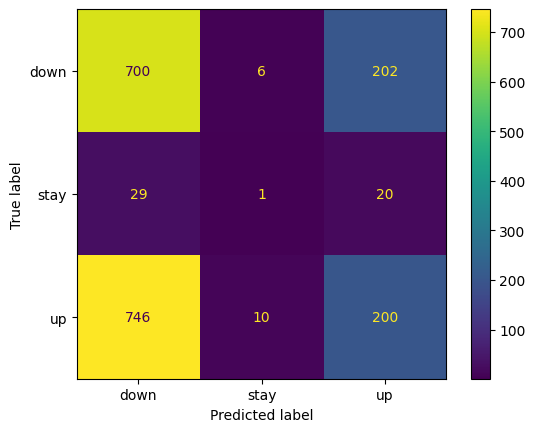

Actual Directions (Previous to Actual): [-1, 1, 1, -1, 1]
Predicted Directions (Previous to Predicted): [-1, -1, 1, -1, -1]
Accuracy: 0.471
Precision (Macro): 0.336
Recall (Macro): 0.333
F1 Score (Macro): 0.303
Confusion Matrix:
 [[700   6 202]
 [ 29   1  20]
 [746  10 200]]


In [59]:
# Derive directions
previous_to_actual = []
previous_to_predicted = []
previous_to_actual_difference = []
previous_to_predicted_difference = []

for i in range(len(all_predictions)):
  previous_to_actual.append(compute_direction(all_actuals[i], test_values_day_of_prediction[i], 0.0001))
  previous_to_predicted.append(compute_direction(all_predictions[i], test_values_day_of_prediction[i], 0.0001))
  previous_to_actual_difference.append(compute_difference(all_actuals[i], test_values_day_of_prediction[i]))
  previous_to_predicted_difference.append(compute_difference(all_predictions[i], test_values_day_of_prediction[i]))

# Step 2: Evaluate classification performance
accuracy = accuracy_score(previous_to_actual, previous_to_predicted)
precision, recall, f1, _ = precision_recall_fscore_support(previous_to_actual, previous_to_predicted, average='macro')  # Macro-average for multiclass
conf_matrix = confusion_matrix(previous_to_actual, previous_to_predicted)

cmd = ConfusionMatrixDisplay(conf_matrix, display_labels=["down", "stay", "up"])
cmd.plot()

plt.savefig('confusionmatrixLSTM.pdf', format='pdf', bbox_inches='tight') # adjust dpi=300 for higher resolution

plt.show()

# Print Results
print("Actual Directions (Previous to Actual):", previous_to_actual[:5])
print("Predicted Directions (Previous to Predicted):", previous_to_predicted[:5])
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision (Macro): {precision:.3f}")
print(f"Recall (Macro): {recall:.3f}")
print(f"F1 Score (Macro): {f1:.3f}")
print("Confusion Matrix:\n", conf_matrix)

In [60]:
label_count_actual = Counter(previous_to_actual)
label_count_predicted = Counter(previous_to_predicted)

print("Label Count Actual:", label_count_actual)
print("Label Count Predicted:", label_count_predicted)

actual_vals_day_of_prediction = []
test_val = DataLoader(test_values_day_of_prediction, batch_size=1)
for batch in test_val:
  actual_vals_day_of_prediction.append(batch)

actual_vals = torch.stack(actual_vals_day_of_prediction, dim=0)

print("Actual Test Values at Day of Prediction: ", actual_vals[:5])

print("Label Values: ", all_actuals[:5])

print("Predicted Values: ",all_predictions[:5])

maeAL = mean_absolute_error(actual_vals, all_actuals)
mseAL = mean_squared_error(actual_vals, all_actuals)
rmseAL = np.sqrt(mseAL)
r2AL = r2_score(actual_vals.numpy(), all_actuals.numpy())

# Print the metrics
print(f"Mean Absolute Error (MAE): {maeAL:.3f}")
print(f"Mean Squared Error (MSE): {mseAL:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmseAL:.3f}")
print(f"R-squared (R2): {r2AL:.3f}")

Label Count Actual: Counter({1: 956, -1: 908, 0: 50})
Label Count Predicted: Counter({-1: 1475, 1: 422, 0: 17})
Actual Test Values at Day of Prediction:  tensor([[0.8329],
        [0.4811],
        [0.2567],
        [0.8049],
        [0.5955]], dtype=torch.float64)
Label Values:  tensor([[0.8085],
        [0.4954],
        [0.2741],
        [0.7556],
        [0.6055]])
Predicted Values:  tensor([[0.8114],
        [0.4775],
        [0.2580],
        [0.7772],
        [0.5898]])
Mean Absolute Error (MAE): 0.023
Mean Squared Error (MSE): 0.002
Root Mean Squared Error (RMSE): 0.041
R-squared (R2): 0.972


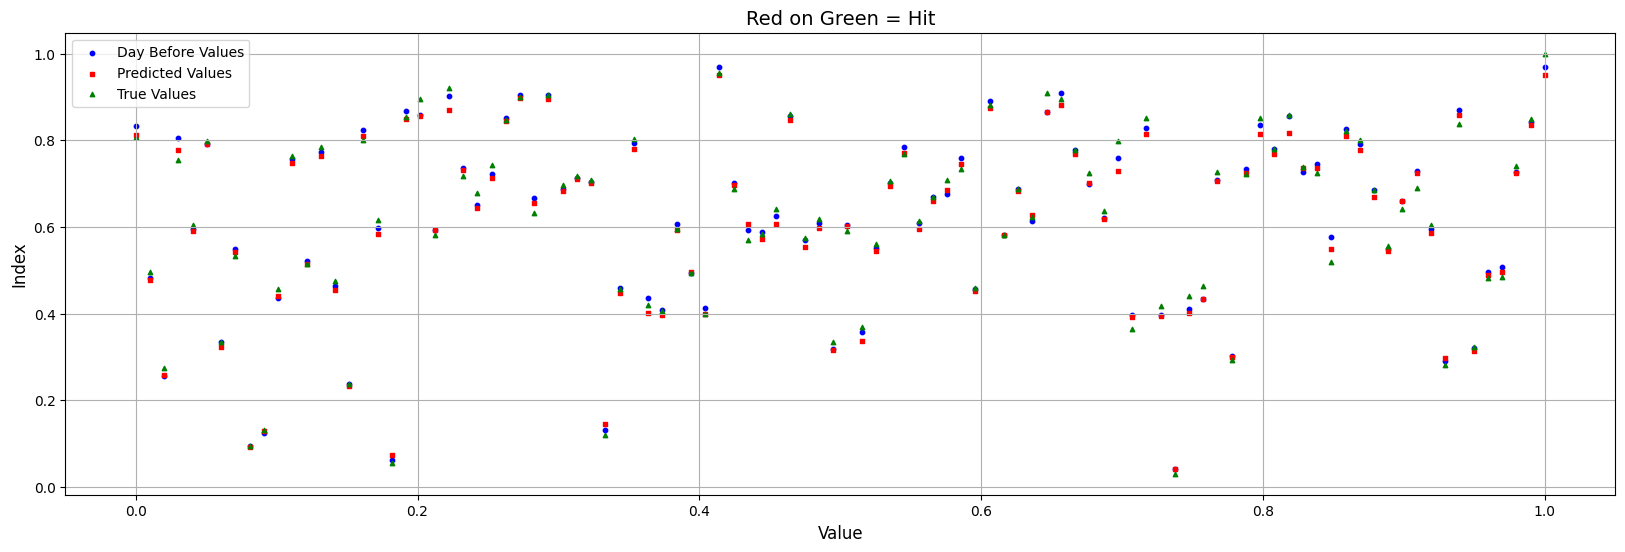

In [61]:
# Create the plot
plt.figure(figsize=(20, 6))

amount = 100

x = np.linspace(0, 1, amount)

# Plot the lines
plt.scatter(x, actual_vals[:amount, :], label="Day Before Values", color="blue", marker="o", s=10)
plt.scatter(x, all_predictions[:amount, :], label="Predicted Values", color="red", marker="s", s=10)
plt.scatter(x, all_actuals[:amount, :], label="True Values", color="green", marker="^", s=10)

# Add titles and labels
plt.title("Red on Green = Hit", fontsize=14)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Index", fontsize=12)

# Add a legend
plt.legend()

# Display the grid
plt.grid(True)

plt.savefig('filingpredictionexamplesLSTM.pdf', format='pdf', bbox_inches='tight') # adjust dpi=300 for higher resolution

# Show the plot
plt.show()

In [62]:
previous_to_predicted_difference

previous_to_actual_difference

previous_to_predicted

previous_to_actual

coloring = []
for i in range(len(previous_to_actual)):
  if(previous_to_actual[i] == 0):
    coloring.append(0)
  elif(previous_to_actual[i] == previous_to_predicted[i]):
    coloring.append(1)
  else:
    coloring.append(-1)

difference_values = []

for i in range(len(previous_to_predicted_difference)):
  difference_values.append(previous_to_predicted_difference[i]-previous_to_actual_difference[i]) #betrag abs

Difference (prediction vs. actual value) in positive (green) and negative (red) predictions

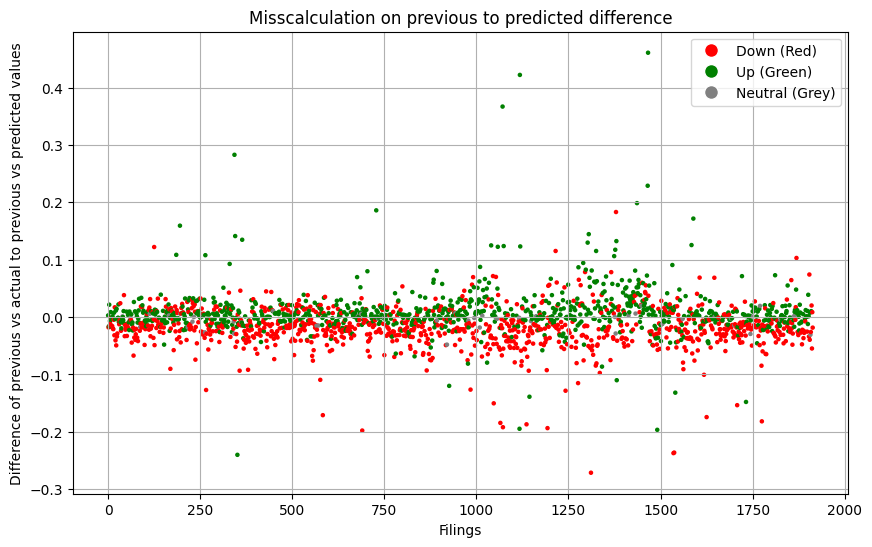

In [63]:
# Assign colors based on the first list
colors = ['grey' if value == 0 else 'green' if value == 1 else 'red' for value in coloring]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.scatter(range(len(difference_values)), difference_values, c=colors, s=5)  # s controls the size of the points

# Adding labels and title
plt.xlabel('Filings')
plt.ylabel('Difference of previous vs actual to previous vs predicted values')
plt.title('Misscalculation on previous to predicted difference')
plt.grid(True)

# Adding a legend manually
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Down (Red)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Up (Green)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=10, label='Neutral (Grey)')
]
plt.legend(handles=legend_elements, loc='best')

plt.savefig('actualdifferencevspredicteddifferenceLSTM.pdf', format='pdf', bbox_inches='tight') # adjust dpi=300 for higher resolution
# Show the plot
plt.show()

# Strategy

- For 10K and 10Qs
- For 8Ks

In [64]:
range1 = test_values_day_of_prediction.indices
range2 = test_tickers_day_of_prediction.indices
range3 = test_values_true.indices
range4 = test_future_values.indices

strategy_df = pd.DataFrame({
    'adj close': test_values_day_of_prediction.dataset[range1],
    'ticker': test_tickers_day_of_prediction.dataset[range2],
    'labels': test_values_true.dataset[range3],
    'future': test_future_values.dataset[range4],
    'predictions': all_predictions.flatten().numpy(force=False)
})

strategy_df.head(1)

,adj close,ticker,labels,future,predictions
0,0.832896,GE,0.808523,0.842751,0.811389


## Denormalize the data

In [65]:
values_to_normalize = ['adj close', 'labels', 'predictions', 'future']

# Step 3: Denormalize the values
for ticker in ticker_list:
    # Retrieve the global min and max for the ticker
    global_min = min_values[ticker]
    global_range = scale_values[ticker]

    # Select the normalized subset for this ticker
    normalized_subset = strategy_df.loc[strategy_df['ticker'] == ticker, values_to_normalize]

    # Apply the denormalization formula
    X_std = (normalized_subset - scaling_min) / (scaling_max - scaling_min)
    original_values = X_std * global_range + global_min

    # Replace the denormalized values back into the DataFrame
    strategy_df.loc[strategy_df['ticker'] == ticker, values_to_normalize] = original_values

strategy_df.head(1)

,adj close,ticker,labels,future,predictions
0,162.597809,GE,158.736374,164.159027,159.190414


In [66]:
for index, row in strategy_df.iterrows():
  if pd.isna(row['future']):
    print(f"NAN value in row {index}")

NAN value in row 762
NAN value in row 1215
NAN value in row 1332
NAN value in row 1838


# Strategies

- with commissions (both sides of the trade)
- always invests everything (not reality, since several events happen on the same day)
- 1: Long, -1: Short, 0: Do nothing (we out)
- Buy and Hold Strategy

In [67]:
starting_capital = 50000
commissions = 5

print('Commission fees total: ', commissions * len(strategy_df) * 2)

Commission fees total:  19140


In [68]:
from collections import Counter

In [69]:
def run_strategy(strategy_df, decision_list, starting_capital, commissions):
  """
  All in Strategy
    - invest everything in every single trade based on the model prediction
    - several trades on the same day use the same amount of capital, this overlaps
    - prediction is made one day into the future

  Args:
    strategy_df (pd.DataFrame):
    decision_list (List[int]):
    starting_capital (float):
    commissions (float):

  Returns:
    portfolio (List[float]): portfolio values
    - where portfolio[t] = value of the portfolio at time/state t
  """

  portfolio = []
  cache = 0
  movement_pred = []

  for i in range(len(strategy_df)):
    event_row = strategy_df.iloc[i]
    stock_price = event_row['adj close']
    stock_price_future = event_row['labels'] # to make a prediction further into the future exchange with future/labels
    if(pd.isna(stock_price_future) or pd.isna(stock_price)):
      continue

    # use all of the starting_capital:
    if (starting_capital > 0):
      amount_bought = (starting_capital - commissions) // stock_price
    else:
      break

    if decision_list[i] == 1:
      cache = starting_capital
      starting_capital = starting_capital - commissions
      starting_capital = starting_capital - (stock_price * amount_bought)

      starting_capital = starting_capital - commissions
      starting_capital = starting_capital + (stock_price_future * amount_bought)

      if (starting_capital > cache):
        movement_pred.append(1)
      else:
        movement_pred.append(0)

      portfolio.append(starting_capital)

    elif decision_list[i] == -1:
      cache = starting_capital
      starting_capital = starting_capital - commissions
      starting_capital = starting_capital - (stock_price * amount_bought)

      difference = stock_price - stock_price_future

      starting_capital = starting_capital - commissions
      starting_capital = starting_capital + ((stock_price + difference) * amount_bought)

      if (starting_capital > cache):
        movement_pred.append(1)
      else:
        movement_pred.append(0)

      portfolio.append(starting_capital)

  return portfolio

In [70]:
# Function to calculate maximum drawdown
def calculate_max_drawdown(portfolio_values):
    """
    Calculate the maximum drawdown of a strategy based on highs and lows

    Args:
      portfolio_values (List[float]): values of the portfolio over time

    Returns:
      max_drawdown (int): Maximum decrease from a high to a low inside the portfolio
      drawdowns (List[int]): List of decreases (drawdowns) from highs to lows
    """
    peak = portfolio_values[0]
    drawdowns = [0]  # No drawdown at the start
    for value in portfolio_values:
        peak = max(peak, value)
        drawdown = (peak - value) / peak  # Drawdown as percentage of peak
        drawdowns.append(drawdown)
    max_drawdown = max(drawdowns)  # The maximum drawdown
    return max_drawdown, drawdowns

## Long and Short only

In [71]:
decision_always_long = []
decision_always_short = []

for i in range(len(strategy_df)):
  decision_always_long.append(1)
  decision_always_short.append(-1)

# Always Long
portfolio_worth_long = run_strategy(strategy_df, decision_always_long, starting_capital, commissions)

# Always Short
portfolio_worth_short = run_strategy(strategy_df, decision_always_short, starting_capital, commissions)

print(portfolio_worth_long[-1])
print(portfolio_worth_short[-1])

mdd_1, drawdowns_1 = calculate_max_drawdown(portfolio_worth_long)
mdd_2, drawdowns_2 = calculate_max_drawdown(portfolio_worth_short)

-7.367243319670962
-3.858839765319189


## Long or Short depending on the Model prediction

In [72]:
model_decisions = []

for i in range(len(strategy_df)):
  event_row = strategy_df.iloc[i]
  stock_price = event_row['adj close']
  prediction = event_row['predictions']
  label = event_row['labels'] # true value

  if prediction < stock_price:
    model_decisions.append(-1)
  elif prediction > stock_price:
    model_decisions.append(1)
  else:
    model_decisions.append(0)

portfolio_worth_model = run_strategy(strategy_df, model_decisions, starting_capital, commissions)

print(portfolio_worth_model[-1])

mdd_3, drawdowns_3 = calculate_max_drawdown(portfolio_worth_model)

351437.821292281


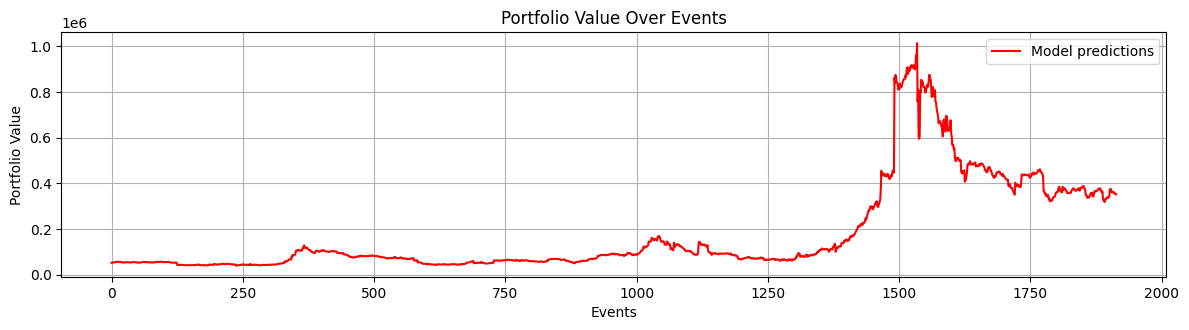

Maximum Drawdown for Portfolio 1: 68.67%
1914


In [73]:
# Plotting the portfolio values and drawdowns
plt.figure(figsize=(12, 6))

# Plot portfolio values for comparison
plt.subplot(2, 1, 1)
plt.plot(portfolio_worth_model, label=f'Model predictions', linestyle='-', color='r')
plt.xlabel('Events')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Events')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()

plt.savefig('modelstrategyLSTM.pdf', format='pdf', bbox_inches='tight')

plt.show()

# Printing maximum drawdowns for each portfolio
print(f"Maximum Drawdown for Portfolio 1: {mdd_3*100:.2f}%")
print(len(portfolio_worth_model))

## Random

In [74]:
import random

In [75]:
# Takes a while
%%script echo skipping
# Adjust based on the prediction length, this differs if only for example 8K filings are selected
list_length = 1914

random_results = []
random_max_drawdowns = []

# Random Walk (average of 1000 runs)
for i in range(1000):
  decision_random_walk = [random.choice([0, 1, -1]) for _ in range(list_length)]
  portfolio_worth_random_walk = run_strategy(strategy_df, decision_random_walk, starting_capital, commissions)
  random_results.append(portfolio_worth_random_walk[-1])
  mdd_4, drawdowns_4 = calculate_max_drawdown(portfolio_worth_random_walk)
  random_max_drawdowns.append(mdd_4)

average_max_drawdown = sum(random_max_drawdowns) / len(random_max_drawdowns)
average_result = sum(random_results) / len(random_results)
print(average_result)
print(average_max_drawdown)

skipping


## Buy and Hold

In [76]:
# Start and end date of data
print(filtered_df['datetime'].min())
print(filtered_df['datetime'].max())

# Price of S&P500 index

# 4524.09 Adj close at 2021-09-01 07:11:01 in USD
beginning_sp500_price = 4524.09
# 5695.94 Adj close at 2024-10-07 16:57:32 in USD
ending_sp500_price = 5695.94

percentage_increase = (ending_sp500_price - beginning_sp500_price) / beginning_sp500_price

print(percentage_increase)

print(beginning_sp500_price * (percentage_increase + 1))

2021-09-01 07:11:01
2024-10-07 16:57:32
0.25902446679884783
5695.94


In [77]:
buy_and_hold = (starting_capital * (percentage_increase + 1)) - 2* commissions

print("Buy and Hold Strategy: ", buy_and_hold)

Buy and Hold Strategy:  62941.223339942386


In [78]:
bandh = [0, 0.2842638410522902, 0, -0.03350311257153127, 0, 0, -0.3395574405981705, 0, -0.1318566739775151, 0, 0, -0.4605608657393345, 0, -0.7722578759925436, 0, 0, 0.22764876184568905, 0, -0.574663850657553, 0, 0, 0.8473996979569742, 0, -0.15511404489350067, 0, 0, -0.9110872450405094, 0, -1.697731100841482, 0, 0, -0.08123585165593639, 0, 0.9519611195260236, 0, 1.2134715784494876, 0, 0, 0.1461009046688222, 0, -0.27763826213396126, 0, 0, -2.0364110556098214, 0, 0.15691842194003325, 0, 0, -1.1909714125195148, 0, 1.149147763018199, 0, 0, -1.2985898136748442, 0, 1.0524514660609219, 0, 0, 0.41027928541854664, 0, 0.8298280656405366, 0, 0, -0.19137230947889883, 0, -0.6865763848056816, 0, -0.24167805585421087, 0, 0, 0.302251448379387, 0, 1.7063101945583359, 0, 0, 0.7460210377712606, 0, 0.337476955709759, 0, 0, 0.7393339551406308, 0, 0.36640298040166996, 0, 0, 0.2995871849622578, 0, -0.10725536274130976, 0, 0, 0.4748196569493546, 0, 0.18197952535197182, 0, 0, -0.5051568068462853, 0, 0.9829281576461124, 0, 0.1949334719149265, 0, 0, 0.18000771431341267, 0, 0.36803630854131963, 0, 0, 0.6461279195357994, 0, 0.4181942361150437, 0, 0, 0.3732799652949259, 0, 0.08877879113036169, 0, 0, -0.3498775895770745, 0, -0.8225823395229703, 0, 0, 0.05509400447352153, 0, 0.7222656026415475, 0, 0, -0.0010739820344718431, 0, 0.3865229864862485, 0, 0, -0.2601625374463401, 0, 0.33847802152713324, 0, -0.1398665559303236, 0, 0, -0.31971365563219223, 0, 0.1657132912945114, 0, 0, 0.22938506357221833, 0, -2.2724822637582465, 0, 0, 1.3200199537034996, 0, -1.896131033450521, 0, 0, -1.1815187417889228, 0, 1.419443613158311, 0, 0, -0.8448563730297565, 0, 1.1730872577451423, 0, 0, 2.0707080374404274, 0, 0.30852853123166657, 0, -0.7181080169894716, 0, 0, 0.9549073338481762, 0, -0.9136167611567658, 0, 0, -0.7470677577436025, 0, 1.6348464630746795, 0, 0, -0.8743415379980468, 0, -1.0287680637092622, 0, 0, -1.138805785140995, 0, 1.7777934551572505, 0, 0, 1.0180197220578835, 0, 0.6223699921661829, 0, 0, 1.383893524747526, 0, -0.10101548486260992, 0, 0.14018951394270118, 0, 0, -0.29897555945093135, 0, -0.2626179913657545, 0, 0, 0.6374052530970564, 0, -0.0629621957060511, 0, 0, -1.9392757790687165, 0, -0.09637690162076495, 0, 0, -0.4050216740091761, 0, -0.14410312534549607, 0, 0, 0.9159984668711818, 0, 0.2817754443029452, 0, 0, -1.42436152864307, 0, 0.08199802697488323, 0, 0, -1.8387945694007368, 0, -0.9689541868338813, 0, -1.103737849414832, 0, 0, -1.8914821867908604, 0, 0.2771738943381896, 0, 0, -1.2171906253646725, 0, -0.1496635847751837, 0, 0, -0.538408875771057, 0, 2.4347646888076113, 0, 0, 1.8885951732779516, 0, 0.686300355780145, 0, 0, 0.942251544733641, 0, -2.4391082077444004, 0, 0, 0.5156929864423399, 0, -0.37017126347429485, 0, 0.8401207191663262, 0, 0, 1.4517207887505545, 0, -1.811572566845976, 0, 0, -1.896945434456343, 0, -0.38405967262932217, 0, 0, 1.5766721170720421, 0, 0.08812077558950637, 0, 0, -2.1173138152195015, 0, -0.71661613961429, 0, 0, -1.0142945264832837, 0, -1.8412122845487655, 0, 0, 1.4956856067329216, 0, 2.237267765560347, 0, -0.24426034406476171, 0, 0, -1.5473503680411893, 0, 1.8642691757321028, 0, 0, -0.5254666430088317, 0, -0.7934042550334475, 0, 0, -2.951815831344917, 0, -0.723375351819977, 0, 0, 2.569824789143582, 0, -0.4291813651667864, 0, 0, -1.2961545123475138, 0, -0.7421002465963666, 0, 0, 2.140857417087094, 0, 2.238376135718223, 0, 0, 1.234781757145198, 0, 1.1662294827948783, 0, -0.043466036210393355, 0, 0, 1.13041136006502, 0, -1.2272698789159042, 0, 0, 1.434391292056647, 0, 0.5066170567449069, 0, 0, 0.7144955276586762, 0, 1.2256547427530462, 0, 0, -0.629370017469788, 0, -1.5652540713177343, 0, 0, 0.34102225843584133, 0, 0.8090938687879357, 0, 0, -1.2551720801807331, 0, -0.9716916613271898, 0, 0.4253385628492534, 0, 0, -0.2651026482054286, 0, -1.687729010355421, 0, 0, -0.3417447717741773, 0, 1.1174577597236057, 0, 0, -1.214413784439794, 0, -0.02048682840329885, 0, 0, 1.6057604355527166, 0, -0.06184750715809706, 0, 0, -1.4752948498371943, 0, -2.7740054250753654, 0, 0, 0.5697936985382235, 0, -2.8146308431003852, 0, 0.20980468517017847, 0, 0, 2.474690007293945, 0, -3.6284507106413955, 0, 0, 0.5675242812353654, 0, 0.48371263814863674, 0, 0, 2.986242108440229, 0, -3.5649708609806985, 0, 0, -0.5674224842484032, 0, -3.2037100632356763, 0, 0, 0.24578974498534745, 0, -1.646320750393837, 0, 0, -0.12959645058717717, 0, 2.386969542307149, 0, 0, -0.3946400929555671, 0, 2.0169632234863677, 0, -4.03952607874526, 0, 0, -0.5833781800992588, 0, 0.014614176965843662, 0, 0, 1.8555039930923556, 0, -0.8120797617175213, 0, 0, 0.9450764734207695, 0, 1.9883256167224195, 0, 0, 2.474226295510973, 0, -0.6274368617659065, 0, 0, -0.7482768681131846, 0, 1.8431018038486124, 0, 0, -1.6347313992415624, 0, 0.3137400778913113, 0, 0.9523393173235029, 0, 0, -1.0793945785935621, 0, -2.379869397635359, 0, 0, -2.9110303335524668, 0, -3.8768430665237275, 0, 0, -0.37736797459957394, 0, 1.4592504858983224, 0, 0, -3.2511951488163437, 0, 0.2200865698254617, 0, 0, 2.4477242280086964, 0, -0.13015723144006452, 0, 0, 0.9532217409177868, 0, 3.056329358583576, 0, -0.2973071533776239, 0, 0, -2.0143036075892073, 0, -0.07117454091590814, 0, 0, -0.8759278267998716, 0, 1.0553814029047315, 0, 0, 0.15841285142366157, 0, 0.35731642904301975, 0, 0, 1.4964587965241805, 0, -0.0830271529819071, 0, 0, -1.1527461422777274, 0, -0.9243878717321574, 0, 0, -0.44569025122100925, 0, -0.299863390215227, 0, 0, 1.9201249359436678, 0, -0.8363571580831342, 0, 2.762829164595959, 0, 0, 0.5895806193263242, 0, 0.986137270919718, 0, 0, -0.9332466976346709, 0, 0.13151670479691902, 0, 0, -1.154320266205866, 0, 2.6156273782937722, 0, 0, 1.2133338697180918, 0, 1.4207760082581844, 0, 0, -0.28230841271976725, 0, -0.6662395550704803, 0, 0, 1.5638477163140152, 0, -0.07773401640558397, 0, -0.16257460597355333, 0, 0, -0.12375507238541195, 0, -0.4248692893594086, 0, 0, 2.1290637641290244, 0, -0.07054739583503, 0, 0, 1.7322368774566943, 0, 0.39695418998517695, 0, 0, 0.18756797165810912, 0, -0.7237794954094601, 0, 0, 0.2269561170191503, 0, -1.2900001139847905, 0, 0, -2.14000649197158, 0, -0.22378626777133093, 0, 0.29161604463010526, 0, 0, 1.4091605518061545, 0, -3.3688058719518743, 0, 0, -0.6666355799502699, 0, -1.1028155571448206, 0, 0, -0.7817025105971265, 0, 0.29962320243361873, 0, 0, -1.0736500458081055, 0, -0.4095056983834944, 0, 0, 1.8341016392734, 0, 0.6610721877456038, 0, 0, 1.5271449816332883, 0, 1.05842727693497, 0, -4.32366134006168, 0, 0, 0.33870120853238816, 0, -1.1317739184353415, 0, 0, -0.7182134089448455, 0, 0.6857100716286535, 0, 0, -1.1272103097361819, 0, -1.7116493600784488, 0, 0, -0.8427580979689431, 0, -1.7232619015461026, 0, 0, -1.0340526208282075, 0, -0.21203598092424114, 0, 0, 1.9672139926234733, 0, -2.1126437880238824, 0, 0, -1.5066695771983274, 0, 2.5883894952576147, 0, 3.0583700679551518, 0, 0, -0.2017948757084831, 0, -1.0245080846639998, 0, 0, -2.8003617786773516, 0, -0.749246363390188, 0, 0, -0.6519175777754405, 0, -0.3290773148014958, 0, 0, 2.596564246086497, 0, -2.366266361565439, 0, 0, 2.6480052302171098, 0, 1.1427569666488724, 0, 0, -0.6672097293450308, 0, -0.7950909706564868, 0, 2.372481982226482, 0, 0, 1.1881976654619875, 0, 1.6266654579669915, 0, 0, -0.7387716072364547, 0, -0.6082610618211248, 0, 0, 2.46263778959277, 0, -0.745440410765752, 0, 0, -0.4101230608784645, 0, -2.500198485734284, 0, 0, -1.058599231542967, 0, 1.3618724670070526, 0, 0, 0.9613981920559844, 0, 0.5597892802462701, 0, -2.077788695478977, 0, 0, 5.543448436034493, 0, 0.9240746788147902, 0, 0, -0.8935777048800997, 0, 0.8713116550319144, 0, 0, -0.8252046497990273, 0, -0.30893228355314273, 0, 0, 0.47585819088147296, 0, -0.3883688698329779, 0, 0, 1.3579987927526016, 0, 0.5914689147847652, 0, 0, -0.02830441976333642, 0, -1.5444192913123267, 0, 0, -0.15918653377758885, 0, 3.0947872397389053, 0, -0.08676332180498347, 0, 0, -0.1194660488065602, 0, -1.7894212283564803, 0, 0, -1.4399194981406072, 0, -0.18623708845491027, 0, 0, 0.752178195750397, 0, -0.7349578247904498, 0, 0, 1.4279296218109305, 0, 0.728966443879342, 0, 0, -0.6052724634100337, 0, -2.4921675023714007, 0, 0, -1.1137750774080746, 0, -0.9007516001852345, 0, 0.10373383615349674, 0, 0, 1.4867993802734736, 0, -1.445169956861636, 0, 0, 0.5868102525282026, 0, -0.4049622110409712, 0, 0, -1.2020638322615351, 0, 1.7461331644819111, 0, 0, -0.25407424823445934, 0, -0.4000548879248611, 0, 0, 0.7538970575044379, 0, -1.1645528874622113, 0, 0, 2.284078102943865, 0, -0.07676325452631305, 0, 0.6978233159061986, 0, 0, 1.2849424614881588, 0, 0.34159058663651987, 0, 0, 0.39968583635343613, 0, -0.20304911890052235, 0, 0, -1.5562598500411085, 0, -0.7638350296294338, 0, 0, 1.8918401045981525, 0, 1.188134498366522, 0, 0, -0.07115031258156934, 0, -0.01817250594663422, 0, 0, 1.1007853469181317, 0, 0.2494840970949097, 0, 0, -1.296874098468337, 0, 1.4642470285510134, 0, 1.045230394459029, 0, 0, 1.4699373244309921, 0, -1.0354610691310495, 0, 0, -0.6140463017754394, 0, 1.287251059802652, 0, 0, -1.1080724476164705, 0, -0.8829796177735161, 0, 0, 0.21952617756952897, 0, 1.1448609342766147, 0, 0, -0.02804145319874607, 0, 0.2773175690496066, 0, 0, -1.3788741489130674, 0, -0.2767405825327751, 0, -2.0041234255327334, 0, 0, -0.1573556145886834, 0, 0.5329429416074394, 0, 0, -1.0537551485558128, 0, 0.30730045671669703, 0, 0, -0.30360018281855305, 0, -0.4725264845680033, 0, 0, 0.7582194086794392, 0, 1.6147737160748799, 0, 0, 0.06871667698291617, 0, -1.5326919115337678, 0, 0, 0.141479401368394, 0, -1.845935787384867, 0, -1.447813845705137, 0, 0, -0.1509761003189447, 0, 1.6476655480623936, 0, 0, -0.698088356543769, 0, 1.7562006217166637, 0, 0, -1.1019457310067593, 0, 0.8918403718310097, 0, 0, 1.2982193897784988, 0, -1.6463223775713631, 0, 0, 0.2984528733375402, 0, 0.5639807253104534, 0, 0, 0.16469543057482383, 0, -0.15738434957162095, 0, 0, 1.423726887983645, 0, 0.5715269388667954, 0, 1.4436542471763847, 0, 0, 0.36988464765423945, 0, -0.5796972083329965, 0, 0, -0.2492370531228194, 0, 0.35791630944272956, 0, 0, 0.09963029974375814, 0, -0.004135247794623265, 0, 0, -0.4134884052006904, 0, 1.326268999363811, 0, 0, -0.20693734728036706, 0, 0.330615690296554, 0, 0, 0.08552202959737354, 0, -0.00842619976980652, 0, -0.595254815297297, 0, 0, 0.09031888869577287, 0, 0.08515791660903549, 0, 0, -1.5810858882773227, 0, -0.3841187197329843, 0, 0, 1.956614972249704, 0, 0.8253202753460531, 0, 0, -0.03861064902076494, 0, -1.1586262936400304, 0, 0, -0.6998305064656485, 0, -0.7218732334382416, 0, 0, 1.8474751389515376, 0, 0.04521286642489297, 0, -0.4579421277258522, 0, 0, 0.44839652634049987, 0, -0.16966239932159066, 0, 0, -0.15833068345566526, 0, 0.2958164439133881, 0, 0, -0.6377683373153031, 0, 1.1890829058788244, 0, 0, 0.9445048649426635, 0, -0.14458676054706077, 0, 0, 0.01550346964389604, 0, -1.122202674755013, 0, 0, -0.7318600335353365, 0, 0.8757581265902425, 0, 0, 1.304908677799732, 0, 0.001660326849850513, 0, -0.6108624209833935, 0, 0, 0.9854453563032717, 0, 1.4534424705965554, 0, 0, -0.20035816359177394, 0, 0.23538963079141606, 0, 0, -0.38120096998572883, 0, 0.6188642614241457, 0, 0, 0.1148059539441082, 0, 0.9321148810237156, 0, 0, 0.6932489951473775, 0, 0.08194255259321714, 0, 0, 1.217813742034668, 0, -0.36716195284263176, 0, -0.47351076976228645, 0, 0, -0.5245281583003636, 0, 0.3710798414438443, 0, 0, -0.7658808766684566, 0, -0.44868382932564677, 0, 0, 1.1455854954693034, 0, -0.035407668843834283, 0, 0, 0.4473544672805918, 0, 1.2269004495714109, 0, 0, 0.11706778016009611, 0, -0.19683184132291975, 0, 0, -0.7922511336500904, 0, -0.28651005386203243, 0, 0.2405026057131332, 0, 0, 0.674221105588857, 0, 0.7411233485312474, 0, 0, 0.8470153458069118, 0, -0.10244071333035398, 0, 0, 0.38553825145495324, 0, 0.7117275205842377, 0, 0, 0.2357910335732072, 0, -0.6756896218903741, 0, 0, 0.03240945218980773, 0, 0.4034153877153557, 0, 0, 0.2814673351556163, 0, -0.015543889679858758, 0, 0, -0.6424666064487883, 0, 0.9877842794752345, 0, 0.14687129405193122, 0, 0, -0.2665087639215691, 0, -1.3839541336347905, 0, 0, -0.25479738404268204, 0, -0.5300074155050516, 0, 0, 0.902409277936278, 0, -0.4218283044793103, 0, 0, -0.7038730380597102, 0, 0.025071394456976925, 0, 0, -0.10696923700230787, 0, 0.5750475751703066, 0, 0, -1.1550909428841738, 0, -0.7555395210577687, 0, -0.7712913029036983, 0, 0, -0.014870682600087726, 0, 0.6879188518795987, 0, 0, -0.2777466728829614, 0, 1.1044879965972587, 0, 0, -1.3457974663146133, 0, 0.6717966037625089, 0, 0, 0.6264619755036449, 0, 1.450830719454621, 0, 0, 0.3833182103508026, 0, -0.1596936512094249, 0, 0, 0.1799129260001031, 0, -0.4194177587506065, 0, -0.6971599351452862, 0, 0, -0.32112659361860363, 0, 0.14266227216406246, 0, 0, 0.6723453106275201, 0, -0.5695885604828921, 0, 0, 0.12416323054647016, 0, 0.8429918867167929, 0, 0, -1.2159612938677844, 0, 0.07212876971294246, 0, 0, -0.2151010615372817, 0, -0.9394794758059599, 0, 0, -1.6400934103219411, 0, -0.22955984771939608, 0, 0.40230650909416354, 0, 0, -1.4734533990868215, 0, 0.022931406074522265, 0, 0, 0.5893173970516585, 0, -0.2709582086142026, 0, 0, 0.007936755559079245, 0, -1.3744071674259506, 0, 0, 0.8109754957160709, 0, -0.1304030159777203, 0, 0, 1.1814893014644445, 0, 0.630385429964031, 0, 0, 0.5207990781392224, 0, 0.429300817103373, 0, 0, -0.624643434611849, 0, -0.5018858888767519, 0, 1.059436938392988, 0, 0, -0.009824505308242415, 0, -1.3399820506516447, 0, 0, -0.8482848196321058, 0, -1.2585283719027562, 0, 0, -0.16855698941634634, 0, 0.7265792222727274, 0, 0, -1.4339628627712542, 0, -1.1832519778109618, 0, 0, -0.48002802297685276, 0, 1.2010022325859904, 0, 0, 0.6474957307233353, 0, 1.0505999486313922, 0, 1.885855702012762, 0, 0, 0.9393730253031363, 0, 0.17529924220356374, 0, 0, 0.28401189192852616, 0, 0.10049156221052513, 0, 0, -0.8083839306732843, 0, 1.5616441094852496, 0, 0, -0.08358389332403515, 0, 1.9075017703661823, 0, 0, 0.15970120755575135, 0, 0.11904273935798848, 0, 0, 0.12820490603360213, 0, 0.7390278097329839, 0, -0.20209310950652926, 0, 0, 0.406112922094648, 0, 0.059687366788407914, 0, 0, -0.1954157460090089, 0, 0.09801185306033133, 0, 0, -0.09462486392383118, 0, 0.37840728581564065, 0, 0, 0.5873742123607695, 0, -0.5408509126972105, 0, 0, -0.056886972616143616, 0, -0.3906202808869552, 0, 0, 0.7968189065892917, 0, 0.40954978699407896, 0, 0, 0.3924494286698943, 0, 0.45993575202152304, 0, 1.3650676351045998, 0, 0, 0.26470624846992585, 0, -0.00762494933082003, 0, 0, 0.45283443669004164, 0, 0.5866407818910568, 0, 0, -1.4684266911006771, 0, 1.030146782120256, 0, 0, 0.16600585268868873, 0, 0.42316894655107795, 0, 0, 0.14304577464787638, 0, 0.03701746080437829, 0, 0, -0.2826475013374963, 0, -0.5660579005492328, 0, -0.8016314922730805, 0, 0, -0.3428381297357008, 0, 0.18256861788026324, 0, 0, 1.4114629309846638, 0, -0.14779006799081618, 0, 0, 0.566597189372442, 0, -0.06710555783868699, 0, 0, 0.07509755941104146, 0, -0.37313402367431525, 0, 0, -0.5616897183990499, 0, 0.8805260963896, 0, 0, 1.2313502764936146, 0, 0.21943252026270788, 0, 0.2921374261968035, 0, 0, 0.08119284117831249, 0, 0.5260365527706368, 0, 0, -0.06517852510764532, 0, 0.7556774896180896, 0, 0, -0.06006499345398986, 0, -1.6105744611597972, 0, 0, 1.2493688211609788, 0, 1.068444607751462, 0, 0, -0.31863375266721894, 0, 0.23104108269635937, 0, 0, 0.8241457963390042, 0, 0.057058326082515265, 0, 0, 0.5742341525559524, 0, -0.09489536011326738, 0, -1.3674255653625456, 0, 0, 0.9579763275017639, 0, 0.5821250684729495, 0, 0, -0.48034698371121065, 0, -0.6005322001165325, 0, 0, 0.1264199922982101, 0, 2.112288421741404, 0, 0, 0.03479475462115911, 0, -0.3786751350190576, 0, 0, 0.17063496993998672, 0, -0.1658155060430544, 0, 0, 0.5229094697149161, 0, 0.800782894888763, 0, -0.11932620709189656, 0, 0, -1.0193100883444606, 0, 0.5141103203274655, 0, 0, 1.0304127925951478, 0, -0.6528519003437983, 0, 0, -0.1122238087346461, 0, 1.1201787981366396, 0, 0, -0.19245297153407392, 0, -0.28710915621273925, 0, 0, -0.6482917484461503, 0, 0.6318059504952345, 0, 0, 0.5649149650123642, 0, 0.8904173912846591, 0, 0.32365354015160275, 0, 0, -0.14021878490156903, 0, -0.30549644525015296, 0, 0, -0.2799795225030266, 0, 0.8630626525532925, 0, 0, 0.11164855071790214, 0, -0.20135845401164643, 0, 0, -0.723905907316913, 0, 0.1091122364688113, 0, 0, -1.2334336350379616, 0, 1.1099194174331695, 0, 0, -0.037463099831791524, 0, 0.14454931932483817, 0, 0, -0.9456980649108493, 0, 0.7444797710585593, 0, -1.455068829580164, 0, 0, -1.202135494776202, 0, -0.20565070133361507, 0, 0, -0.5780602724641426, 0, -0.2208160119998248, 0, 0, -0.875854812743615, 0, 0.8731248071466746, 0, 0, 1.1964576270872662, 0, 0.02130100613548791, 0, 0, -0.4576430353515626, 0, 1.020914263474304, 0, 0, 0.31784486665891176, 0, -1.5730513586862171, 0, -0.34354388154940185, 0, 0, 0.9128437077573048, 0, 1.2556739721478527, 0, 0, 1.032612390701182, 0, 0.13434298232750663, 0, 0, -0.0005835618166138978, 0, 0.5090947698625836, 0, 0, 0.1649398844549843, 0, -0.024130405535727206, 0, 0, 0.4837813139759728, 0, 1.1715927882596233, 0, 0, -0.20816677921287052, 0, 0.11647735102702228, 0, 0.09163899374069473, 0, 0, 0.2501874243978186, 0, -0.2706123039226127, 0, 0, -0.7380789485015526, 0, 0.700104258816947, 0, 0, 0.02488018529340774, 0, -0.7367046509680453, 0, 0, -0.5975035585443322, 0, 0.802787620486467, 0, 0, 0.11160825806737495, 0, 0.15028090913065117, 0, 0, 1.1847649793331305, 0, -0.019981663563317653, 0, 0, -0.11152197300303701, 0, 0.25808546645145203, 0, 0.27103813151374556, 0, 0, 0.8503672791998707, 0, 0.23446558536817097, 0, 0, -0.0393860697500914, 0, 0.7664386564552705, 0, 0, 0.2521327394745754, 0, -0.25259318472709014, 0, 0, -0.1562130321101196, 0, -0.3065171894990004, 0, 0, 0.39335900157368986, 0, 0.15724312002203256, 0, 0, 0.09073212238914774, 0, -0.4083652583445674, 0, 0.26755639309195, 0, 0, 0.6195317856513505, 0, 0.5084444409779065, 0, 0, 0.5448765178485582, 0, 0.10166989647510949, 0, 0, 0.07410719362856977, 0, 1.0208065293514812, 0, 0, -0.8763028841120457, 0, 0.5517027074430692, 0, 0, 0.28262026252154904, 0, 0.6389375498743188, 0, 0, -1.3927543241993745, 0, -0.7816403936922511, 0, -0.7140265531926926, 0, 0, 1.079203564940956, 0, -0.1558102589770738, 0, 0, -2.314909375473495, 0, -0.5142620237842288, 0, 0, 1.1090468702846357, 0, 0.08133101292933098, 0, 0, -0.49601718780302173, 0, 1.5793398659167401, 0, 0, -1.3693502993456064, 0, -1.8381860868696753, 0, 0, -2.996879838863975, 0, 1.0354085880061037, 0, 0, -0.7734647858502863, 0, 2.3042611519136447, 0, 0.46716768495385086, 0, 0, 0.004303397765514916, 0, 1.6847579753558328, 0, 0, 0.38237284285767004, 0, 1.6133247764330783, 0, 0, 0.1989779357261412, 0, 0.9722284736913167, 0, 0, -0.19845553982971165, 0, 0.4239676828782013, 0, 0, -0.8932805548120926, 0, 1.148337085011919, 0, 0, -0.31537266931381813, 0, 0.15951960865450143, 0, -0.597597320797616, 0, 0, -0.003937906806072977, 0, 1.0093051774424433, 0, 0, -2.115107439771169, 0, -0.16025435809103872, 0, 0, -0.3018017615584734, 0, -1.7260249859284649, 0, 0, 1.15800702824842, 0, 0.4472672652839682, 0, 0, 1.0665025888896507, 0, 0.7495302358939249, 0, 0, 0.5407711405364557, 0, 0.12566297656613212, 0, 0.026455008109871336, 0, 0, -0.2896455862498093, 0, 1.697685316676334, 0, 0, -0.19410273951238066, 0, 0.2809273058532735, 0, 0, 0.25111788443470395, 0, -0.18612489301417234, 0, 0, 0.403867571712313, 0, -0.12532169669905446, 0, 0, 0.42365525811767224, 0, -0.9324107094664358, 0, 0, 0.013839090212397487, 0, -0.1681413492255035, 0, 0.8970249395274354, 0]

Adjust the range of the loop depending on the selected filings:

- len(bandh) for all filings
- 1386 for 8k filings
- len(bandh) - 529 for 10k filings

In [79]:
portfolio_worth_bandh = []

money_change = 0
starting_cap = starting_capital

for i in range(len(bandh)):
  if bandh[i] > 0.0:
    money_change = starting_capital * (bandh[i] / 100)
  elif bandh[i] < 0.0:
    money_change = starting_capital * (bandh[i] / 100)
  else:
    money_change = 0.0

  starting_cap = starting_cap + money_change
  portfolio_worth_bandh.append(starting_cap)

print(portfolio_worth_bandh[-1])
mdd_4, drawdowns_4 = calculate_max_drawdown(portfolio_worth_bandh)

64349.286840089946


## Visualize the Strategies

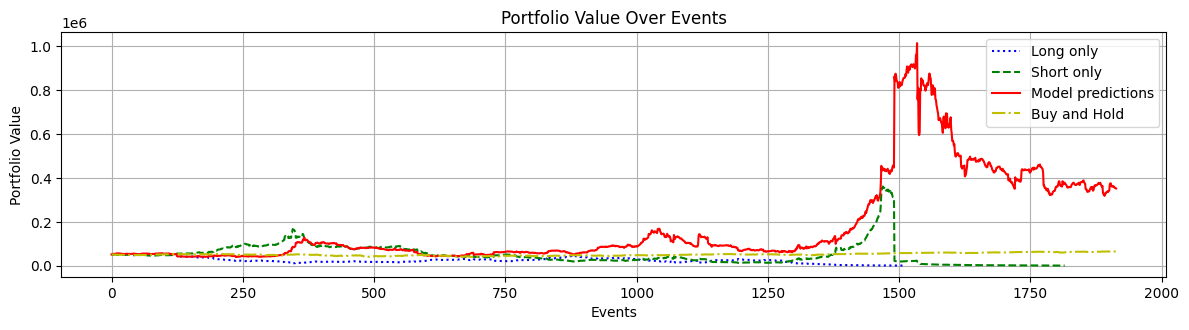

Maximum Drawdown for Portfolio 1: 100.01%
Maximum Drawdown for Portfolio 2: 100.00%
Maximum Drawdown for Portfolio 3: 68.67%
Maximum Drawdown for Portfolio 4: 25.50%


In [80]:
# Plotting the portfolio values and drawdowns
plt.figure(figsize=(12, 6))

# Plot portfolio values for comparison
plt.subplot(2, 1, 1)
plt.plot(portfolio_worth_long, label=f'Long only', linestyle=':', color='b')
plt.plot(portfolio_worth_short, label=f'Short only', linestyle='--', color='g')
plt.plot(portfolio_worth_model, label=f'Model predictions', linestyle='-', color='r')
plt.plot(portfolio_worth_bandh, label=f'Buy and Hold', linestyle='-.', color='y')
plt.xlabel('Events')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Events')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()

plt.savefig('strategiesLSTM.pdf', format='pdf', bbox_inches='tight')

plt.show()

# Printing maximum drawdowns for each portfolio
print(f"Maximum Drawdown for Portfolio 1: {mdd_1*100:.2f}%")
print(f"Maximum Drawdown for Portfolio 2: {mdd_2*100:.2f}%")
print(f"Maximum Drawdown for Portfolio 3: {mdd_3*100:.2f}%")
print(f"Maximum Drawdown for Portfolio 4: {mdd_4*100:.2f}%")